In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import pyemma
import nglview
import glob
import matplotlib as mpl
import msmtools
import os
import scipy
from scipy import stats
import seaborn as sns
import pandas as pd
from subprocess import call
import sys
defaults_location = sys.path[0]
sns.set_style("ticks")

In [2]:
%cd ~/D4P

/home/jabella/D4P


In [3]:
num_trajs = 0
for i in range(1000):
    if os.path.exists(str(i).zfill(4) + "/output.dcd"): num_trajs += 1
    else: break
print("The number of trajectories found is:", num_trajs)    

The number of trajectories found is: 300


## Visualize Trajectory

Replace `trajindex` with the foldername that contains the trajectory to visualize.

In [25]:
import nglview
from matplotlib.colors import to_hex

widget = nglview.NGLWidget()
widget.clear_representations()

trajindex = "0061"
topfile = glob.glob(trajindex + "/aln*.pdb")[0]

s = md.load(topfile)
traj = md.load(trajindex + "/output.dcd", top=topfile)
widget.add_trajectory(traj)

widget

NGLWidget(max_frame=25000)

## Compute Statistics on data and Prepare for Analysis

In [4]:
# Featurize trajectories based on the residue-residue peptide-MHC and peptide-peptide distances 
# Check terminal for progress
for i in range(num_trajs):
    if not os.path.exists(str(i).zfill(4) + "/pep_to_MHC/Y.npy"): 
        print("Featurizing traj:", i)
        call(["python " + defaults_location + "/featurize.py " + str(i).zfill(4)], shell=True)

In [5]:
# Because there is no bounding box in the implicit solvent simulations, 
# trajectories must be removed that unbind and travel far from the binding site
traj_to_exclude = [] 
global_traj_indices = np.array([gi for gi in np.arange(num_trajs) if gi not in traj_to_exclude])
local_traj_indices = [li for li, gi in enumerate(global_traj_indices)]

In [6]:
steps_to_nanoseconds = 1.0 / 25
num_trajs = len(global_traj_indices)

In [7]:
# Compute RMSD of ends to peptide to the starting structure
# assumes the first traj comes from umbrella sampling that starts with the native state
crystal_location = glob.glob("0000/aln-*.pdb")[0] 
print(crystal_location)

nanchor_atoms = md.load(crystal_location).top.select("chainid == 1 and type != H and resid == 181")
canchor_atoms = md.load(crystal_location).top.select("chainid == 1 and type != H and resid == 188")
crystal_peptide_n = md.load(crystal_location, atom_indices=nanchor_atoms)
crystal_peptide_c = md.load(crystal_location, atom_indices=canchor_atoms)
COM_n = md.compute_center_of_mass(crystal_peptide_n)[0]
COM_c = md.compute_center_of_mass(crystal_peptide_c)[0]

feats_rmsd_n = []
feats_rmsd_c = []
for i in global_traj_indices:
    i_str = str(i).zfill(4)
    #if (i % 100) == 0: print(i)
    if os.path.exists(i_str + "/anchor_rmsds.npz"):
        anchor_rmsd_file = np.load(i_str + "/anchor_rmsds.npz", allow_pickle=True)
        feats_rmsd_n_i = anchor_rmsd_file["feats_rmsd_n"]
        feats_rmsd_c_i = anchor_rmsd_file["feats_rmsd_c"]
        feats_rmsd_n.append(feats_rmsd_n_i)
        feats_rmsd_c.append(feats_rmsd_c_i)
        continue
    
    print(i)

    topfile = glob.glob(i_str + "/aln*.pdb")[0]
    pep_nanchor_atoms = md.load(i_str + "/output.dcd", top=topfile).top.select("chainid == 1 and type != H and resid == 181")
    pep_canchor_atoms = md.load(i_str + "/output.dcd", top=topfile).top.select("chainid == 1 and type != H and resid == 188")

    peptide_i = md.load(i_str + "/output.dcd", top=topfile, atom_indices=pep_nanchor_atoms)
    dCOM = md.compute_center_of_mass(peptide_i)
    feats_rmsd_n_i = np.linalg.norm(dCOM - COM_n, axis=1)
    feats_rmsd_n.append(feats_rmsd_n_i)
    #feat = md.rmsd(peptide_i, crystal_peptide_n)
    #feats_rmsd_n.append(feat)

    peptide_i = md.load(i_str + "/output.dcd", top=topfile, atom_indices=pep_canchor_atoms)
    dCOM = md.compute_center_of_mass(peptide_i)
    feats_rmsd_c_i = np.linalg.norm(dCOM - COM_c, axis=1)
    feats_rmsd_c.append(feats_rmsd_c_i)
    #feat = md.rmsd(peptide_i, crystal_peptide_c)
    #feats_rmsd_c.append(feat)

    np.savez_compressed(i_str + "/anchor_rmsds.npz", feats_rmsd_n=feats_rmsd_n_i, feats_rmsd_c=feats_rmsd_c_i)

feats_rmsd_n = np.array(feats_rmsd_n)
feats_rmsd_c = np.array(feats_rmsd_c)
print(feats_rmsd_n.shape, feats_rmsd_c.shape)

0000/aln-D4P-start.pdb
(294, 25001) (294, 25001)


(7350294,) (7350294,)


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aec590d30>)

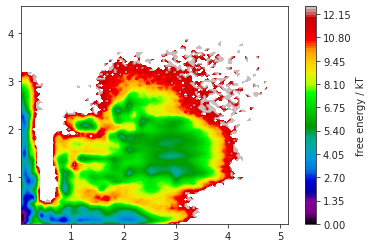

In [8]:
# Plot histogram of anchor RMSDs from starting structure
feats_rmsd_n_concat = np.concatenate(feats_rmsd_n)
feats_rmsd_c_concat = np.concatenate(feats_rmsd_c)
print(feats_rmsd_n_concat.shape, feats_rmsd_c_concat.shape)

pyemma.plots.plot_free_energy(feats_rmsd_n_concat, feats_rmsd_c_concat)

In [9]:
# Compute peptide-MHC distance as defined by the closest residue-residue distance (closest pair of heavy atoms)
pep_mhc_indices = []
beg = 0
end = 180
for i in range(9):
    pep_mhc_indices += range(beg, end)
    beg += 188
    end += 188

pep_pep_indices = []
beg = 180
end = 188
for i in range(9):
    pep_pep_indices += range(beg, end)
    beg += 188
    end += 188

feats = []
for i in global_traj_indices:
    i_str = str(i).zfill(4)
    if os.path.exists(i_str + "/pmhc_dist.npz"):
        pmhc_dist_file = np.load(i_str + "/pmhc_dist.npz", allow_pickle=True)
        feat = pmhc_dist_file["feats"]
        feats.append(feat)
        continue
    
    print(i)
    
    x = np.load(i_str + "/pep_to_MHC/Y.npy")

    #feat = np.min(x[:, pep_mhc_indices], axis=1)
    #feats.append(feat)

    feat = np.min(x[:, pep_mhc_indices], axis=1)
    feat_max = np.minimum(feat, 1.0) # cap the p-MHC distance
    feats.append(feat_max)
    np.savez_compressed(i_str + "/pmhc_dist.npz", feats=feat_max)
    
feats = np.array(feats)
print(feats.shape)

(294, 25001)


In [10]:
num_n_bound = 0
num_c_bound = 0
for i in range(len(feats_rmsd_n)):
    if not os.path.exists(str(global_traj_indices[i]).zfill(4) + "/us_info.npz"): continue
    #print(i, global_traj_indices[i])
    if np.sum(feats[i] > 0.5) == 0: continue
    if np.sum(np.logical_and(feats_rmsd_n[i] < 0.2, feats_rmsd_c[i] > 1.0)) > 0: num_n_bound += 1
    elif np.sum(np.logical_and(feats_rmsd_n[i] > 1.0, feats_rmsd_c[i] < 0.2)) > 0: num_c_bound += 1
print("The number of umbrella sampling traj with N-term bound, C-term detached:", num_n_bound)
print("The number of umbrella sampling traj with N-term detached, C-term bound:", num_c_bound)

The number of umbrella sampling traj with N-term bound, C-term detached: 3
The number of umbrella sampling traj with N-term detached, C-term bound: 12


In [11]:
# Compute the rmsd of the peptide relative to its starting conformation
crystal_pep_heavy_atoms = md.load(crystal_location).top.select("chainid == 1 and type != H")
crystal_peptide = md.load(crystal_location, atom_indices=crystal_pep_heavy_atoms)
print(crystal_peptide)

feats_rmsd = []
for i in global_traj_indices:
    i_str = str(i).zfill(4)
    if os.path.exists(i_str + "/pmhc_rmsd.npz"):
        pmhc_rmsd_file = np.load(i_str + "/pmhc_rmsd.npz", allow_pickle=True)
        feat_rmsd = pmhc_rmsd_file["feats_rmsd"]
        feats_rmsd.append(feat_rmsd)
        continue
        
    print(i)
    
    topfile = glob.glob(i_str + "/aln*.pdb")[0]
    pep_heavy_atoms = md.load(i_str + "/output.dcd", top=topfile).top.select("chainid == 1 and type != H")
    peptide_i = md.load(i_str + "/output.dcd", top=topfile, atom_indices=pep_heavy_atoms)
    feat = md.rmsd(peptide_i, crystal_peptide)
    feats_rmsd.append(feat)

    np.savez_compressed(i_str + "/pmhc_rmsd.npz", feats_rmsd=feat)
    
feats_rmsd = np.array(feats_rmsd)
print(feats_rmsd.shape)

<mdtraj.Trajectory with 1 frames, 76 atoms, 9 residues, without unitcells>
(294, 25001)


294 294
(7350294,) (7350294,)


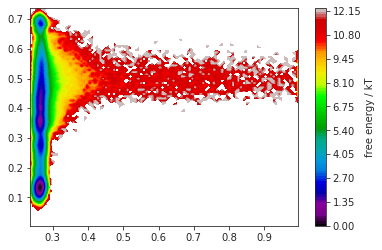

In [12]:
print(len(feats), len(feats_rmsd))
feats_concat = np.concatenate(feats) #, axis=0)
feats_rmsd_concat = np.concatenate(feats_rmsd) #, axis=0)
pyemma.plots.plot_free_energy(feats_concat, feats_rmsd_concat)

#plt.xlim([0,0.5])
print(feats_concat.shape, feats_rmsd_concat.shape)

In [1]:
if False: # save random sample of confs in macrostates
    confs0 = []
    confs1 = []
    confs2 = []
    confs3 = []
    confs4 = []
    for i in range(len(feats)):
        for j in range(len(feats[i])):
            if feats[i][j] > 0.5: confs4.append((i,j))
            elif feats_rmsd[i][j] < 0.2: confs0.append((i,j))
            elif feats_rmsd_n[i][j] < 0.2 and feats_rmsd_c[i][j] > 0.2: confs1.append((i,j))
            elif feats_rmsd_n[i][j] > 0.2 and feats_rmsd_c[i][j] < 0.2: confs2.append((i,j))
            else: confs3.append((i,j))
    print(len(confs0), len(confs1), len(confs2), len(confs3), len(confs4))
    all_confs = [confs0, confs1, confs2, confs3, confs4]
    for j,confs in enumerate(all_confs):
        print(j)
        random_subset = np.random.choice(len(confs), size=100, replace=False)
        confs = np.array(confs)
        all_obj = []
        for t,f in confs[random_subset]:
            topfile = glob.glob(str(global_traj_indices[t]).zfill(4) + "/*.pdb")[0]
            trajfile = str(global_traj_indices[t]).zfill(4) + "/output.dcd"
            all_obj.append(md.load_frame(trajfile, f, top=topfile))
        full_traj = all_obj[0]
        for i in range(1,100): 
            try: full_traj += all_obj[i]
            except: continue
        full_traj.save_dcd("/home/jabella/D4P/example_confs/confs" + str(j) + ".dcd")

In [14]:
if False: # concatenate us trajectories that fully detach
    num_us_trajs = 0
    num_detached = 0
    trajs = []
    for i in range(len(feats_rmsd_c)):
        i_str = str(global_traj_indices[i]).zfill(4)
        if not os.path.exists(i_str + "/us_info.npz"): continue
        num_us_trajs += 1
        is_detached = list(np.logical_and(feats_rmsd_n[i] > 1.0, feats_rmsd_c[i] > 1.0))
        #is_detached = list(feats[i] > 0.5)
        if np.sum(is_detached) > 0: 
            num_detached += 1
            topfile = glob.glob(i_str + "/aln-*.pdb")[0]
            traj = md.load(i_str + "/output.dcd",top=topfile)
            when_detached = is_detached.index(True)
            traj = traj[:when_detached+30]
            if when_detached < 250: continue
            traj_smooth = traj.smooth(width=250)
            trajs.append(traj_smooth[::50])
            print(i, global_traj_indices[i], when_detached)
    num_reg_trajs = len(global_traj_indices) - num_us_trajs
    print(num_detached, num_us_trajs, num_reg_trajs)
    full_traj_concat = trajs[0]
    for i in range(1, len(trajs)): full_traj_concat += trajs[i]
    full_traj_concat.save_dcd("/home/jabella/Downloads/traj_concat.dcd")

## TICA

In [221]:
# Load trajectories
traj_filenames = [str(i).zfill(4) for i in global_traj_indices]
inp_str = []
for traj_folder in traj_filenames:
    input_prefix = traj_folder + "/pep_to_MHC"
    inp_i = input_prefix + "/Y.npy"
    inp_str.append(inp_i)

inp = pyemma.coordinates.source(inp_str)

In [17]:
# Compute tica timescales as a function of lag time - WARNING: may take a few hours
TICA_lagtimes = 25*np.array([1,10,25,50,75,100,250,500])
if os.path.exists("tica_timescales.npz"):
    f = np.load("tica_timescales.npz")
    lags = f["lags"]
    all_tica_timescales = f["timescales"]
else:
    all_tica_timescales = []
    for l in TICA_lagtimes:
        print("lag:",l)
        tica_obj_temp = pyemma.coordinates.tica(inp, lag=l, commute_map=True, kinetic_map=False, dim=50)
        tica_timescales = tica_obj_temp.timescales
        all_tica_timescales.append(tica_timescales)
    np.savez_compressed("tica_timescales.npz", lags=TICA_lagtimes, timescales=all_tica_timescales)

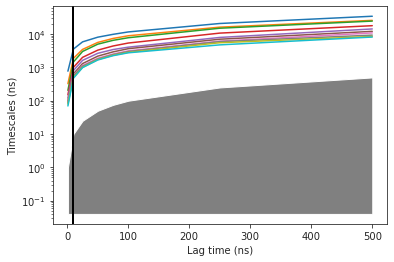

In [19]:
# Plot tica timescales as a function of lag time
lags = TICA_lagtimes
nlags = lags.shape[0]
ts_list = np.zeros((nlags, 10))
for i, lag in enumerate(lags):
    timescales = all_tica_timescales[i]
    ts_list[i, :] = timescales[:10]

ts_list *= steps_to_nanoseconds

plt.semilogy(lags * steps_to_nanoseconds, ts_list)
plt.ylabel('Timescales (ns)')
plt.xlabel('Lag time (ns)')
plt.fill_between(lags * steps_to_nanoseconds, 1*steps_to_nanoseconds, lags * steps_to_nanoseconds, facecolor='Gray')

plt.axvline(10, linewidth=2, color='black')
plt.savefig('pics/tica_ts_over_lags.png', dpi=500)

In [15]:
# Run TICA
if not os.path.exists("tica_coor.npz"):
    tica_obj = pyemma.coordinates.tica(inp, lag=10*25, commute_map=True, kinetic_map=False, dim=50) #, weights="koopman")
    tica_y = tica_obj.get_output(dimensions=np.arange(30))
    tica_obj.save("tica","tica",overwrite=True)
    print("Saving")
    np.savez_compressed("tica_coor.npz",tica_y=tica_y)
else:
    print("Loading")
    #tica_obj = pyemma.load("../native_state_us/tica","wild")
    tica_obj = pyemma.load("tica","tica")
    tica_y = np.load("tica_coor.npz", allow_pickle=True)["tica_y"]

Loading


/home/jabella/miniconda2/envs/py3/lib/python3.6/site-packages/pyemma/_base/serialization/pickle_extensions.py:46: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(name) as h5f:
/home/jabella/miniconda2/envs/py3/lib/python3.6/site-packages/pyemma/_base/serialization/pickle_extensions.py:52: UserWarning: BLOSC compression filter unavailable. Your resulting file may be large and not optimal to process.
  warnings.warn('BLOSC compression filter unavailable. '


In [16]:
# Extract the top 5 features that are most correlated with TICA dimensions
feat_des = np.load("feats_des.npz")['feat']
print(feat_des.shape)
num_feats = 5
tica_corr = tica_obj.feature_TIC_correlation
for i in range(5):
    TIC_i = abs(tica_corr)[:, i]
    sorted_ind_i = np.argsort(TIC_i)
    print(feat_des[sorted_ind_i][-num_feats:])
    print(TIC_i[sorted_ind_i][-num_feats:])

(1692,)
['RES_DIST (closest-heavy) LYS3 - MET97'
 'RES_DIST (closest-heavy) LYS3 - ALA117'
 'RES_DIST (closest-heavy) LYS3 - GLN96'
 'RES_DIST (closest-heavy) LYS3 - GLN115'
 'RES_DIST (closest-heavy) LYS3 - HIS114']
[138.61701341 138.98688899 139.09565785 139.74194837 140.23250232]
['RES_DIST (closest-heavy) LEU9 - ASP119'
 'RES_DIST (closest-heavy) LEU9 - GLN96'
 'RES_DIST (closest-heavy) LEU9 - GLY120'
 'RES_DIST (closest-heavy) LEU9 - ALA117'
 'RES_DIST (closest-heavy) LEU9 - TYR116']
[90.16982284 90.92380423 91.12495859 91.6605116  92.25177185]
['RES_DIST (closest-heavy) LYS3 - LEU8'
 'RES_DIST (closest-heavy) LEU9 - LYS3'
 'RES_DIST (closest-heavy) LYS3 - LEU9'
 'RES_DIST (closest-heavy) PHE2 - LEU8'
 'RES_DIST (closest-heavy) LEU8 - PHE2']
[58.75534133 58.7793298  58.7793298  59.52633098 59.52633098]
['RES_DIST (closest-heavy) LEU8 - LEU168'
 'RES_DIST (closest-heavy) LEU8 - THR163'
 'RES_DIST (closest-heavy) ASN5 - ALA69'
 'RES_DIST (closest-heavy) ASN5 - LYS3'
 'RES_DIST (clos

(7350294, 30)


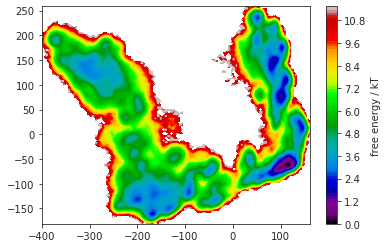

In [17]:
# Raw TICA space
Y_concat = np.concatenate(tica_y, axis=0)
print(Y_concat.shape)
pyemma.plots.plot_free_energy(Y_concat[:,0], Y_concat[:,1])
plt.savefig('pics/tica_notweighted.png', dpi=500)

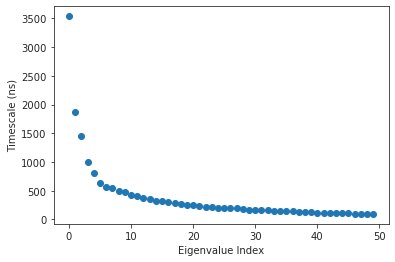

In [18]:
# TICA timescales for the chosen lag time
tica_timescales = tica_obj.timescales * steps_to_nanoseconds
plt.scatter(np.arange(len(tica_timescales))[:50], tica_timescales[:50])

plt.xlabel("Eigenvalue Index")
plt.ylabel("Timescale (ns)")
plt.savefig('pics/tica_ts.png')

## Discretization

In [19]:
# Cluster TICA space using Kmeans
if os.path.exists("discretization2.npz"):
    f = np.load("discretization2.npz", allow_pickle=True)
    dtrajs = list(f['dtrajs'])
    cc_all = f['cc_all']
    index_clusters = f['index_clusters']
    n_clusters = len(index_clusters)
    f.close()
else:
    new_trajs = []
    for j in range(len(global_traj_indices)):
        feat_j = feats[j].reshape(len(feats[j]),1) # These are other features that have been tried
        feat_rmsd_j = feats_rmsd[j].reshape(len(feats_rmsd[j]),1)
        feat_rmsd_n_j = feats_rmsd_n[j].reshape(len(feats_rmsd_n[j]),1)
        feat_rmsd_c_j = feats_rmsd_c[j].reshape(len(feats_rmsd_c[j]),1)

        new_trajs.append(tica_y[j][:, :2])
        
    clustering = pyemma.coordinates.cluster_kmeans(new_trajs, k=100, max_iter=20, stride=25)

    n_clusters = clustering.n_clusters
    cc_all = clustering.clustercenters
    index_clusters = clustering.index_clusters
    index_clusters_shapes = [ici.shape[0] for ici in index_clusters]

    dtrajs = clustering.dtrajs
    print(n_clusters)
    
    np.savez_compressed("discretization2.npz", dtrajs=dtrajs, cc_all=cc_all, index_clusters=index_clusters)
    

0.28955724835395813


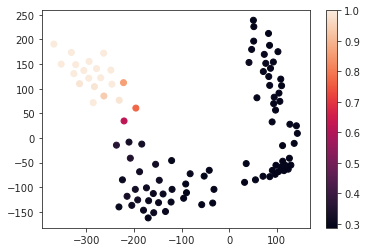

In [20]:
# plot pMHC distance
cluster_feats = []
for j in range(len(index_clusters)):
    cluster = index_clusters[j]
    conf_feats = []
    for i in range(len(cluster)):
        trajindex, frameindex = cluster[i]
        conf_feats.append(feats[trajindex][frameindex])
    aggregated_feats = np.max(conf_feats)
    cluster_feats.append(aggregated_feats)

cluster_feats = [min(1.0, c) for c in cluster_feats]
cluster_feats = np.array(cluster_feats)
print(cluster_feats[-1])
plt.scatter(cc_all[:, 0], cc_all[:, 1], c=cluster_feats)
plt.colorbar()

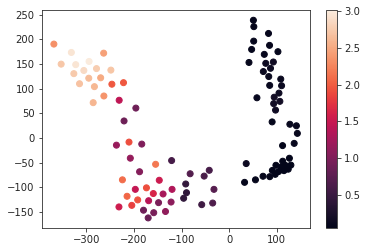

In [21]:
# plot rmsd of n-term anchor
cluster_feats_rmsd = []
for j in range(len(index_clusters)):
    cluster = index_clusters[j]
    conf_feats_1 = []
    conf_feats_2 = []
    for i in range(len(cluster)):
        trajindex, frameindex = cluster[i]
        conf_feats_1.append(feats_rmsd_n[trajindex][frameindex])
        conf_feats_2.append(feats_rmsd_c[trajindex][frameindex])
    aggregated_feats_1 = np.median(conf_feats_1)
    aggregated_feats_2 = np.median(conf_feats_2)
    cluster_feats_rmsd.append((aggregated_feats_1, aggregated_feats_2))

cluster_feats_rmsd = np.array(cluster_feats_rmsd)
plt.scatter(cc_all[:, 0], cc_all[:, 1], c=cluster_feats_rmsd[:,0])
plt.colorbar()

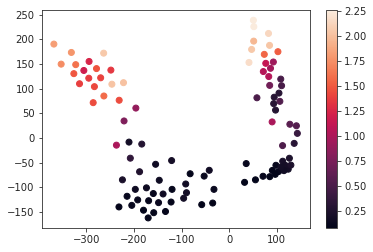

In [22]:
# plot rmsd of c-term anchor
plt.scatter(cc_all[:, 0], cc_all[:, 1], c=cluster_feats_rmsd[:,1])
plt.colorbar()

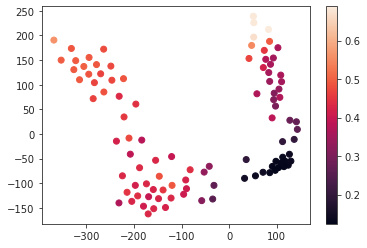

In [23]:
# rmsd from native state
cluster_feats_r = []
for j in range(len(index_clusters)):
    cluster = index_clusters[j]
    conf_feats = []
    for i in range(len(cluster)):
        trajindex, frameindex = cluster[i]
        conf_feats.append(feats_rmsd[trajindex][frameindex])
    aggregated_feats = np.median(conf_feats)
    cluster_feats_r.append(aggregated_feats)

cluster_feats_r = np.array(cluster_feats_r)
plt.scatter(cc_all[:, 0], cc_all[:, 1], c=cluster_feats_r)
plt.colorbar()

In [24]:
# stats of count matrix
c_matrix = msmtools.estimation.cmatrix(dtrajs, 250*25, sparse_return=False)
largest_connected_set = msmtools.estimation.largest_connected_set(c_matrix)

unbound_states = []
associated_states = []
for i,c in enumerate(cluster_feats):
    if c >= 0.5: 
        unbound_states.append(i)
    else: associated_states.append(i)
                
a_to_u = np.sum(c_matrix[associated_states, :][:, unbound_states])
u_to_a = np.sum(c_matrix[unbound_states, :][:, associated_states])
u_to_u = np.sum(c_matrix[unbound_states, :][:, unbound_states])
a_to_a = np.sum(c_matrix[associated_states, :][:, associated_states])
print(a_to_u, u_to_a, u_to_u, a_to_a)
print(a_to_u+u_to_a+u_to_u+a_to_a)
print(np.sum(c_matrix.sum()))
        
print(c_matrix.shape, largest_connected_set.shape)

30195.0 401.0 633607.0 4848591.0
5512794.0
5512794.0
(100, 100) (100,)


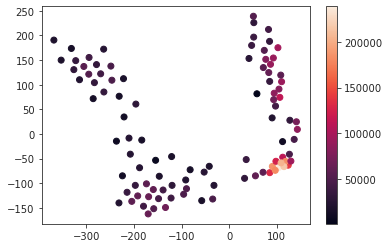

In [25]:
# number of transitions originating from state
plt.scatter(cc_all[:, 0], cc_all[:, 1], c=np.sum(c_matrix, axis=1)) #c=np.minimum(400, np.sum(c_matrix, axis=1)))
plt.colorbar()

In [26]:
# state definitions
unbound_states = []
associated_states = []
native_states = []
cterm_bound_states = []
nterm_bound_states = []
anchor_cutoff = 0.2
for i in range(len(cluster_feats)):
    nterm_rmsd, cterm_rmsd = cluster_feats_rmsd[i]
    if cluster_feats_r[i] < 0.2: native_states.append(i)
    elif nterm_rmsd >= anchor_cutoff and cterm_rmsd < anchor_cutoff: cterm_bound_states.append(i)
    elif nterm_rmsd < anchor_cutoff and cterm_rmsd >= anchor_cutoff: nterm_bound_states.append(i)
    elif cluster_feats[i] > 0.5: unbound_states.append(i)
    else: associated_states.append(i)
print(unbound_states, native_states, cterm_bound_states, nterm_bound_states)

not_native = associated_states + unbound_states + cterm_bound_states + nterm_bound_states
n_to_nn = np.sum(c_matrix[native_states, :][:, not_native])
nn_to_n = np.sum(c_matrix[not_native, :][:, native_states])

print(len(native_states))
print(n_to_nn, nn_to_n)
print(np.sum(c_matrix[native_states, :][:, cterm_bound_states]), np.sum(c_matrix[native_states, :][:, nterm_bound_states]))
print(np.sum(c_matrix[cterm_bound_states, :][:, native_states]), np.sum(c_matrix[nterm_bound_states, :][:, native_states]))

[3, 7, 13, 16, 19, 25, 30, 37, 38, 40, 43, 49, 53, 62, 70, 71, 84, 88, 90, 93, 95] [2, 6, 14, 20, 22, 23, 28, 34, 47, 54, 56, 58, 72, 75, 76, 78, 81, 98] [1, 5, 10, 15, 17, 21, 24, 26, 27, 31, 33, 35, 39, 44, 46, 50, 51, 60, 61, 67, 68, 77, 83, 85, 87, 91, 94, 97] [0, 4, 8, 9, 18, 29, 32, 36, 41, 45, 48, 52, 55, 57, 64, 65, 66, 69, 74, 79, 80, 82, 86, 89, 96, 99]
18
86790.0 24020.0
46402.0 37924.0
567.0 23452.0


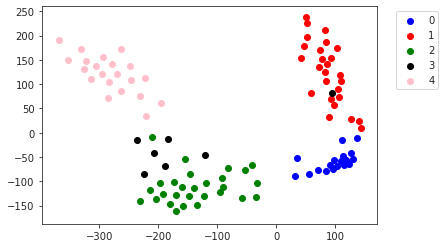

In [27]:
plt.scatter(cc_all[native_states, 0], cc_all[native_states, 1], c="b")
plt.scatter(cc_all[nterm_bound_states, 0], cc_all[nterm_bound_states, 1], c="r")
plt.scatter(cc_all[cterm_bound_states, 0], cc_all[cterm_bound_states, 1], c="g")
plt.scatter(cc_all[associated_states, 0], cc_all[associated_states, 1], c="black")
plt.scatter(cc_all[unbound_states, 0], cc_all[unbound_states, 1], c="pink")
plt.legend(["0", "1", "2", "3", "4"], loc="upper right", bbox_to_anchor=(1.2, 1))

In [28]:
# Compute z-dist for reweighting umbrella sampling simulations
kT = 2.479
umbrella_sampling_g_indices = []
umbrella_sampling_l_indices = []
us_trajs = []
md_trajs = []
us_centers = []
us_force_constants = []
unbiased_g_trajs = []
unbiased_l_trajs = []

for progress, i in enumerate(global_traj_indices):
    if os.path.exists(str(i).zfill(4) + "/dCOM.npz"):
        dCOM = np.load(str(i).zfill(4) + "/dCOM.npz", allow_pickle=True)["dCOM"]
    else:
        print(i)
        file_prefix = str(i).zfill(4) + "/"
        topfile = glob.glob(file_prefix + "aln*.pdb")[0]
        f = md.load(file_prefix + "output.dcd", top=topfile)
        peptide = f.top.select("chainid == 1")
        mhc = f.top.select("chainid != 1 and name == 'CA' and (resi < 45 or (resi >= 95 and resi <= 120))")

        peptide_frame = f.atom_slice(atom_indices=peptide, inplace=False)
        mhc_frame = f.atom_slice(atom_indices=mhc, inplace=False)

        pep_com = md.compute_center_of_mass(peptide_frame)
        mhc_com = md.compute_center_of_mass(mhc_frame)

        dCOM = np.abs(pep_com - mhc_com)[:,2]
        np.savez_compressed(str(i).zfill(4) + "/dCOM.npz", dCOM=dCOM)
        
    if os.path.exists(str(i).zfill(4) + "/us_info.npz"):
        us_info_file = np.load(str(i).zfill(4) + "/us_info.npz", allow_pickle=True)
        us_centers.append(us_info_file["center"])
        us_force_constants.append(us_info_file["force_constant"] / kT)
        us_trajs.append(dCOM)
        umbrella_sampling_g_indices.append(i)
        umbrella_sampling_l_indices.append(progress)
        
    else:
        md_trajs.append(dCOM)
        unbiased_g_trajs.append(i)
        unbiased_l_trajs.append(progress)
        
        
#us_centers = np.array(us_centers)
#us_force_constants = np.array(us_force_constants)
print(len(us_trajs), len(md_trajs))
print(us_centers)
print(us_force_constants)

us_dtrajs = [dtrajs[i] for i in umbrella_sampling_l_indices]
md_dtrajs = [dtrajs[i] for i in unbiased_l_trajs]

63 231
[array(1.), array(1.1), array(1.2), array(1.3), array(1.4), array(1.5), array(1.6), array(1.7), array(1.8), array(1.9), array(2.), array(2.1), array(2.2), array(2.3), array(2.4), array(2.5), array(2.6), array(2.7), array(2.8), array(2.9), array(3.), array(1.), array(1.1), array(1.2), array(1.3), array(1.4), array(1.5), array(1.6), array(1.7), array(1.8), array(1.9), array(2.), array(2.1), array(2.2), array(2.3), array(2.4), array(2.5), array(2.6), array(2.7), array(2.8), array(2.9), array(3.), array(2.), array(2.1), array(2.2), array(2.3), array(2.4), array(2.5), array(2.6), array(2.7), array(2.9), array(3.), array(2.), array(2.1), array(2.2), array(2.3), array(2.4), array(2.5), array(2.6), array(2.7), array(2.8), array(2.9), array(3.)]
[40.338846308995564, 40.338846308995564, 40.338846308995564, 40.338846308995564, 40.338846308995564, 40.338846308995564, 40.338846308995564, 40.338846308995564, 40.338846308995564, 40.338846308995564, 40.338846308995564, 40.338846308995564, 40.33

63 231
100


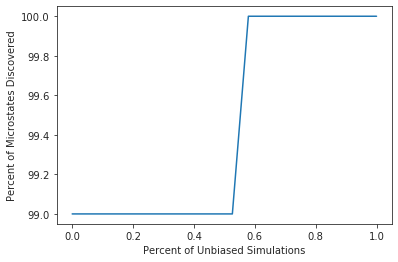

In [29]:
#sns.set_context("notebook")
print(len(us_dtrajs), len(md_dtrajs))
all_trajs_concat = np.concatenate((us_dtrajs + md_dtrajs), axis=0)
print(len(set(all_trajs_concat)))
num_discovered_states = []
unbiased_percentages = np.linspace(0,1,20) #[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
for p in unbiased_percentages:
    num_unbiased = int(np.floor(len(md_dtrajs) * p))
    #print(num_unbiased)
    all_trajs_concat = np.concatenate((us_dtrajs + md_dtrajs[:num_unbiased]), axis=0)
    num_discovered_states.append(len(set(all_trajs_concat)))
plt.plot(unbiased_percentages, num_discovered_states)
plt.xlabel("Percent of Unbiased Simulations")
plt.ylabel("Percent of Microstates Discovered")
plt.savefig('pics/microstates_over_unbiased.png')

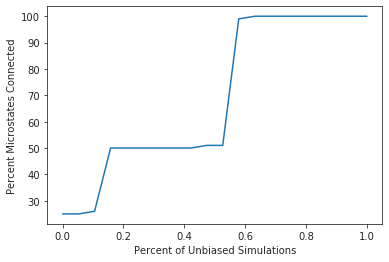

In [30]:
num_largest_set = []
unbiased_percentages = np.linspace(0,1,20) #[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
for p in unbiased_percentages:
    num_unbiased = int(np.floor(len(md_dtrajs) * p))
    c_matrix = msmtools.estimation.cmatrix(us_dtrajs + md_dtrajs[:num_unbiased], 250*25, sparse_return=False)
    largest_connected_set = msmtools.estimation.largest_connected_set(c_matrix)
    num_largest_set.append(len(largest_connected_set))
plt.plot(unbiased_percentages, num_largest_set)
plt.xlabel("Percent of Unbiased Simulations")
plt.ylabel("Percent Microstates Connected")
plt.savefig('pics/connection_over_unbiased.png')

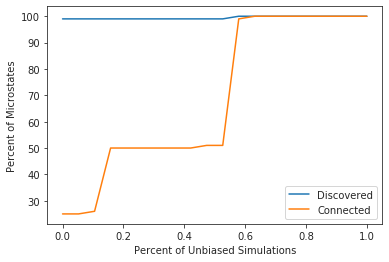

In [31]:
#sns.set_context("notebook")
#sns.set_style("ticks")
plt.plot(unbiased_percentages, num_discovered_states)
plt.plot(unbiased_percentages, num_largest_set)
plt.legend(["Discovered","Connected"])
#plt.ylim([40,105])
plt.xlabel("Percent of Unbiased Simulations")
plt.ylabel("Percent of Microstates")
plt.savefig('pics/both_over_unbiased.png', dpi=500)

In [32]:
print(len(us_trajs))
print([t.shape for t in us_trajs])
print(len(index_clusters))
print([len(c) for c in index_clusters])

63
[(25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,), (25001,)]
100
[128391, 68317, 201872, 68812, 38990, 35676, 149147, 34333, 104203, 50986, 54739, 13590, 113183, 54567, 91181, 60770, 57002, 52635, 41686, 32120, 169618, 99328, 54831, 288103, 8205, 44083, 36135, 27192, 46089, 47080, 44820, 70678, 42761, 36966, 265581, 60060, 74528, 17244, 18437, 50881, 76829, 131305, 24860, 24940, 87790, 115663, 74238, 311174, 28847, 44909, 9

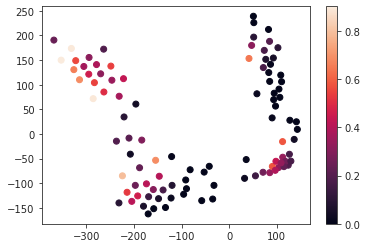

In [33]:
# Plot the percentage of conformations per cluster that originated from umbrella sampling
# This can also be used as a way for selecting restarting conformations for adaptive sampling
from collections import Counter
num_us_per_cluster = np.zeros(len(index_clusters),)
for dtraj in us_dtrajs:
    c = Counter(dtraj)
    for i in range(len(index_clusters)):
        num_us_per_cluster[i] += c[i]
num_per_cluster = np.array([len(c) for c in index_clusters])
percent_us_per_cluster = num_us_per_cluster / num_per_cluster
plt.scatter(cc_all[:, 0], cc_all[:, 1], c=percent_us_per_cluster)
plt.colorbar()

## Adaptive sampling

(100,)
(51420, 2) 334 334
0.9999999999999997


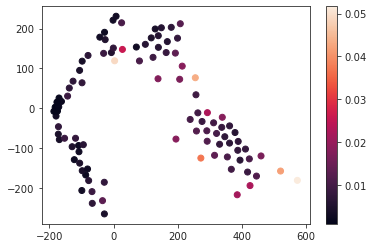

In [39]:
c_matrix = msmtools.estimation.cmatrix(dtrajs, 250*25, sparse_return=False)
num_start = np.sum(c_matrix, axis=1)
print(num_start.shape)
# number of transitions originating from state

print(index_clusters[0].shape, len(dtrajs), len(global_traj_indices))
cluster_weight = 1 / num_start
cluster_weight /= np.sum(cluster_weight)
print(np.sum(cluster_weight))
plt.scatter(cc_all[:, 0], cc_all[:, 1], c=cluster_weight) 
plt.colorbar()

In [41]:
# Choose based on discrete space
# use this cell to exclude clusters that are not directly apart of the binding/unbinding pathway
cluster_indices = np.array([i for i in np.arange(len(index_clusters))])
cluster_weight = cluster_weight[cluster_indices]
cluster_weight /= np.sum(cluster_weight)

In [42]:
clusters_chosen = np.random.choice(cluster_indices, size=20, p=cluster_weight, replace=True)
confs_chosen = []
for c in clusters_chosen:
    cluster_confs = index_clusters[c]
    conf_chosen = np.random.choice(np.arange(len(cluster_confs)))
    confs_chosen.append(cluster_confs[conf_chosen])

(8350334, 30)
0.24390636
0.26011112
0.26718923
0.27207357
0.2638655
0.26389343
0.26532024
0.25062996
0.25824055
0.24897619
0.2756932
0.27471015
0.26311046
0.2659233
0.26888767
0.25038534
0.27717254
0.25351122
0.25053734
0.26059172


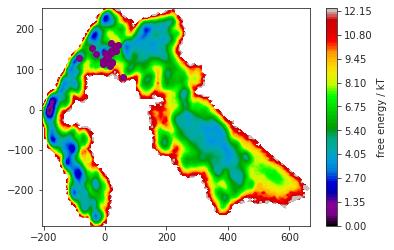

In [43]:
# Project new restarting conformations onto TICA plot
Y_concat = np.concatenate(tica_y, axis=0)
print(Y_concat.shape)
pyemma.plots.plot_free_energy(Y_concat[:,0], Y_concat[:,1])

for conf in confs_chosen:
    trajindex, frameindex = conf
    print(feats[trajindex][frameindex])
    plt.scatter(tica_y[trajindex][frameindex, 0], tica_y[trajindex][frameindex, 1], c='purple')

In [52]:
# Setup next round of adaptive sampling simulations
folder_index = 380 # set start value here
for conf in confs_chosen:
    new_folder_name = str(folder_index).zfill(4)
    if os.path.exists("as/" + new_folder_name): 
        print("Folder exists, will exit.")
        break
    trajindex, frameindex = conf
    conf_folder = str(global_traj_indices[trajindex]).zfill(4)
    topfile = glob.glob(conf_folder + "/aln-*.pdb")[0]
    conf_filename = "aln-traj" + conf_folder + "-frame" + str(frameindex) + ".pdb"
    print(conf_filename)
    call(["mdconvert -t " + topfile + " -i " + str(frameindex) + " -o " + conf_filename + " " + conf_folder + "/output.dcd"], shell=True)
    call(["mv " + conf_filename + " as/"], shell=True)
    
    os.chdir("as/")
    
    call(["python setup_sim.py " + new_folder_name + " " + new_folder_name + " " + conf_filename], shell=True)
    call(["rm " + conf_filename], shell=True)
    os.chdir("..")
    
    folder_index += 1
    
    

aln-traj0208-frame2063.pdb
aln-traj0208-frame2091.pdb
aln-traj0208-frame2971.pdb
aln-traj0190-frame397.pdb
aln-traj0208-frame4639.pdb
aln-traj0180-frame22232.pdb
aln-traj0208-frame3964.pdb
aln-traj0208-frame4456.pdb
aln-traj0343-frame5782.pdb
aln-traj0208-frame4758.pdb
aln-traj0208-frame2610.pdb
aln-traj0351-frame3787.pdb
aln-traj0180-frame20580.pdb
aln-traj0208-frame3744.pdb
aln-traj0208-frame3315.pdb
aln-traj0208-frame2053.pdb
aln-traj0208-frame3585.pdb
aln-traj0211-frame3575.pdb
aln-traj0180-frame15127.pdb
aln-traj0359-frame2397.pdb


## Compute MSM

In [34]:
# Compute MSM timescales as a function of lag time (See bootstrap section for error bars)
all_msm_lags = 25*np.array([1,10,25,50,75,100,250,500])
#all_msm_lags = 25*np.array([1,10,25,50,75,100,200,300,500])
if os.path.exists("msm_timescales.npz"):
    f = np.load("msm_timescales.npz", allow_pickle=True)
    lags = f["lags"]
    all_msm_timescales = f["timescales"]
else:
    all_msm_timescales = []
    for l in all_msm_lags:
        print("lag:",l)
        us_temp = pyemma.thermo.estimate_umbrella_sampling(us_trajs=us_trajs, us_dtrajs=us_dtrajs, 
                                                  us_centers=us_centers, us_force_constants=us_force_constants,
                                                  md_trajs=md_trajs, md_dtrajs=md_dtrajs, estimator="dtram", lag=l, 
                                                  width=None, save_convergence_info=1, maxiter=10000)#, maxerr=1E-6)

        MSM = us_temp.msm
        timescales = MSM.timescales()
        all_msm_timescales.append(timescales)
    np.savez_compressed("msm_timescales.npz", lags=all_msm_lags, timescales=all_msm_timescales)
    

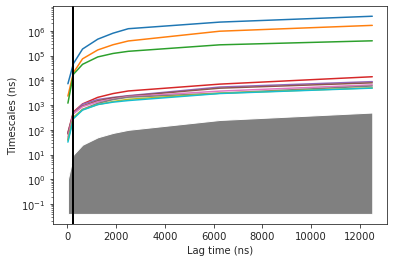

In [35]:
lags = all_msm_lags
nlags = lags.shape[0]
ts_list = np.zeros((nlags, 10))
for i, lag in enumerate(lags):
    timescales = all_msm_timescales[i]
    ts_list[i, :] = timescales[:10]

ts_list *= steps_to_nanoseconds

plt.semilogy(lags, ts_list)
plt.ylabel('Timescales (ns)')
plt.xlabel('Lag time (ns)')
plt.fill_between(lags, 1*steps_to_nanoseconds, lags * steps_to_nanoseconds, facecolor='Gray')

#plt.axvline(250*25, linewidth=2, color='black')
plt.axvline(250, linewidth=2, color='black')
#plt.xlim(0,2000)

In [34]:
# Compute MSM - set the lagtime 
if os.path.exists("us_obj"):
    us = pyemma.load("us_obj","us_obj")
    MSM = pyemma.load("msm_obj","msm_obj")

    active_set = us.active_set
    mu = us.stationary_distribution
    nstates = us.nstates
    us_lag = 250
    us_lag_ns = 250*steps_to_nanoseconds
else:
    us_lag = 250*25
    us = pyemma.thermo.estimate_umbrella_sampling(us_trajs=us_trajs, us_dtrajs=us_dtrajs, 
                                                  us_centers=us_centers, us_force_constants=us_force_constants,
                                                  md_trajs=md_trajs, md_dtrajs=md_dtrajs, estimator="dtram", lag=us_lag, 
                                                  width=None, save_convergence_info=1, maxiter=10000)#, maxerr=1E-6)
    
    MSM = us.msm

    active_set = us.active_set
    mu = us.stationary_distribution
    nstates = us.nstates
    
    us.save("us_obj","us_obj",overwrite=True)
    MSM.save("msm_obj","msm_obj",overwrite=True)

(0, 0.001)

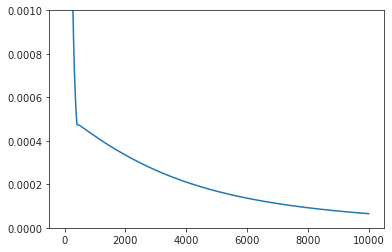

In [35]:
plt.plot(us.increments)
plt.ylim([0, 1E-3])

[]


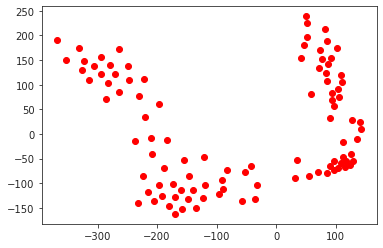

In [36]:
# Visualize clusters not in active set
not_in_active_set = [i for i in range(len(cc_all)) if i not in active_set]
print(not_in_active_set)
dim0 = 0
dim1 = 1
plt.scatter(cc_all[active_set, dim0], cc_all[active_set, dim1], c="r")
plt.scatter(cc_all[not_in_active_set, dim0], cc_all[not_in_active_set, dim1], c="b")

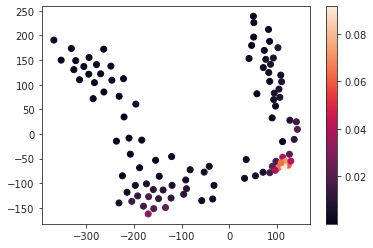

In [37]:
# Visualize stationary distribution
plt.scatter(cc_all[active_set, 0], cc_all[active_set, 1], c=mu)
plt.colorbar()

[47470.43157711 20362.83093047 17557.82104129   528.01141877
   475.71289533   458.64585634   453.16007626   313.90948923
   312.89185848   282.5540122 ]


Text(0, 0.5, 'MSM Timescale (ns)')

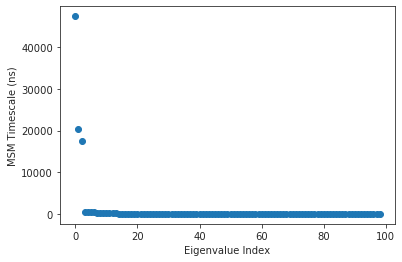

In [39]:
# Plot timescales for the chosen lag time
timescales = MSM.timescales() * steps_to_nanoseconds
print(timescales[:10])
plt.scatter(np.arange(len(timescales)), timescales)
plt.xlabel("Eigenvalue Index")
plt.ylabel("MSM Timescale (ns)")

In [40]:
# Distribute stationary probabilities of each cluster to each conformation
weights = []
dtrajs_concat = np.concatenate(dtrajs, axis=0)
mu = us.stationary_distribution
for cluster_index in dtrajs_concat:
    if cluster_index not in active_set: weights.append(0.0)
    else:
        MSM_cluster_index = np.where(active_set == cluster_index)[0][0]
        num_conf_in_cluster = len(index_clusters[cluster_index])
        weights.append(mu[MSM_cluster_index] / num_conf_in_cluster)

print(np.sum(weights))

0.9999999999999996


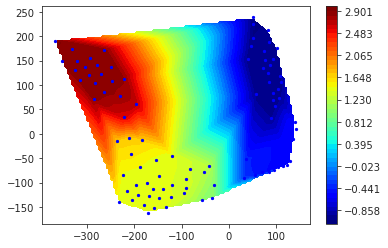

In [41]:
# Visualize specific eigenvector
r2 = MSM.eigenvectors_right()[:, 1]
pyemma.plots.scatter_contour(cc_all[MSM.active_set, 0], cc_all[MSM.active_set, 1], r2)

[3, 7, 13, 16, 19, 25, 30, 37, 38, 40, 43, 49, 53, 62, 70, 71, 84, 88, 90, 93, 95]


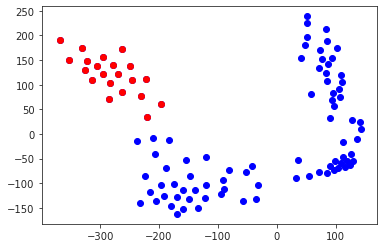

In [42]:
# Visualize unbound states
unbound_states = []
for i,c in enumerate(cluster_feats):
    if c >= 0.5 and i in active_set: 
    #if i in MSM.active_set and MSM.metastable_assignments[np.argwhere(MSM.active_set == i)[0][0]] == 4:
        unbound_states.append(np.argwhere(active_set == i)[0][0])
print(unbound_states)
dim0 = 0
dim1 = 1
plt.scatter(cc_all[active_set, dim0], cc_all[active_set, dim1], c="b")
plt.scatter(cc_all[active_set[unbound_states], dim0], cc_all[active_set[unbound_states], dim1], c="r")

In [43]:
# state definitions - MSM version
unbound_states = []
associated_states = []
native_states = []
cterm_bound_states = []
nterm_bound_states = []
anchor_cutoff = 0.2
state_to_macrostate = []
print(nstates, len(active_set))
active_set_coords = []
for MSM_state in range(nstates):
    cluster_index = active_set[MSM_state]
    active_set_coords.append(cc_all[cluster_index])
    nterm_rmsd, cterm_rmsd = cluster_feats_rmsd[cluster_index]
    #if nterm_rmsd < anchor_cutoff and cterm_rmsd < anchor_cutoff: native_states.append(MSM_state)
    if cluster_feats_r[cluster_index] < 0.2: 
        native_states.append(MSM_state)
        state_to_macrostate.append(0)
    elif nterm_rmsd >= anchor_cutoff and cterm_rmsd < anchor_cutoff: 
        cterm_bound_states.append(MSM_state)
        state_to_macrostate.append(2)
    elif nterm_rmsd < anchor_cutoff and cterm_rmsd >= anchor_cutoff: 
        nterm_bound_states.append(MSM_state)
        state_to_macrostate.append(1)
    #elif cluster_index == len(index_clusters) - 1: unbound_states.append(MSM_state)
    elif cluster_feats[cluster_index] > 0.5: 
        unbound_states.append(MSM_state)
        state_to_macrostate.append(4)
    else: 
        associated_states.append(MSM_state)
        state_to_macrostate.append(3)
#print(unbound_states, native_states, cterm_bound_states, nterm_bound_states)
print(len(unbound_states))
macro_p = [np.sum(mu[native_states]), np.sum(mu[nterm_bound_states]), np.sum(mu[cterm_bound_states]), np.sum(mu[associated_states]), np.sum(mu[unbound_states])]
print(np.sum(macro_p))
print(macro_p)

100 100
21
0.9999999999999999
[0.5735395146922192, 0.1348714707482288, 0.2542638272543921, 0.01057597950135608, 0.02674920780380378]


In [44]:
# dG of binding estimate - See bootstrap section for estimation with error bars
bound_states = associated_states + native_states + cterm_bound_states + nterm_bound_states
RT = 2.479
dG = RT*np.log(np.sum(mu[unbound_states]) / np.sum(mu[bound_states]))
print("p(Bound):", np.sum(mu[bound_states]))
print("p(Unbound):", np.sum(mu[unbound_states]))
print("RT*ln(p_unbound / p_bound):", dG)

p(Bound): 0.973250792196196
p(Unbound): 0.02674920780380378
RT*ln(p_unbound / p_bound): -8.909865480129552


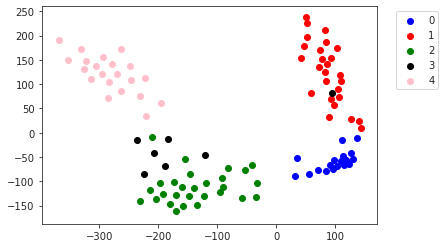

In [45]:
plt.scatter(cc_all[active_set[native_states], 0], cc_all[active_set[native_states], 1], c="b")
plt.scatter(cc_all[active_set[nterm_bound_states], 0], cc_all[active_set[nterm_bound_states], 1], c="r")
plt.scatter(cc_all[active_set[cterm_bound_states], 0], cc_all[active_set[cterm_bound_states], 1], c="g")
plt.scatter(cc_all[active_set[associated_states], 0], cc_all[active_set[associated_states], 1], c="black")
plt.scatter(cc_all[active_set[unbound_states], 0], cc_all[active_set[unbound_states], 1], c="pink")
plt.legend(["0", "1", "2", "3", "4"], loc="upper right", bbox_to_anchor=(1.2, 1))
plt.savefig('pics/macrostate_clusters.png', dpi=500, bbox_inches='tight')

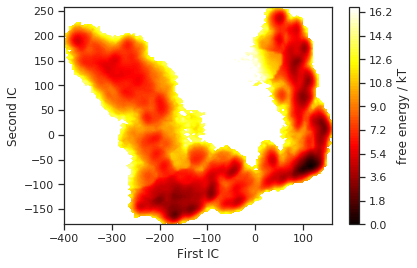

In [46]:
sns.set_context("notebook")
sns.set_style("ticks")
pyemma.plots.plot_free_energy(Y_concat[:,0], Y_concat[:,1], weights=weights, cmap=plt.cm.hot) #, cbar_orientation="horizontal", cbar=False,ax=ax)
plt.xlabel("First IC")
plt.ylabel("Second IC")
plt.savefig('pics/tica_reweighted.png', dpi=500, bbox_inches="tight")

In [49]:
tica_x_concat = []
tica_y_concat = []
macrostate_traj_concat = []
for t,dtraj in enumerate(dtrajs):
    for i,cluster_index in enumerate(dtraj):
        if cluster_index not in active_set: continue
        MSM_cluster_index = np.where(active_set == cluster_index)[0][0]
        tica_x_concat.append(tica_y[t][i,0])
        tica_y_concat.append(tica_y[t][i,1])
        macrostate_traj_concat.append(state_to_macrostate[MSM_cluster_index])


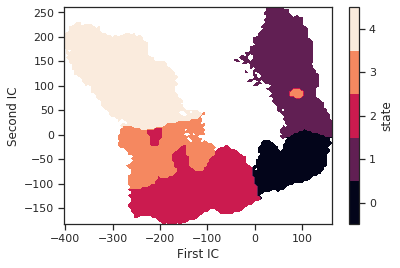

In [50]:
sns.set_style("ticks")
pyemma.plots.plot_state_map(np.array(tica_x_concat), np.array(tica_y_concat), np.array(macrostate_traj_concat), ncontours=5, cbar_label="state")
plt.xlabel("First IC")
plt.ylabel("Second IC")
plt.savefig('pics/tica_reweighted_labeled.png', dpi=500, bbox_inches="tight")

In [51]:
# Compute contact probabilities between the peptide with itself
if not os.path.exists("contact_prob_peppep.npz"):
    print("Computing contacts")
    is_contact = []
    for i in global_traj_indices:
        if i%10 == 0: print(i)
        i_str = str(i).zfill(4)    
        x = np.load(i_str + "/pep_to_MHC/Y.npy")
        #print(x.shape, x[:,pep_mhc_indices].shape)
        is_contact.append(x[:,pep_pep_indices] < 0.35)

    print("Organizing")
    contacts_per_macrostate = [[] for i in range(5)]
    from collections import defaultdict
    contact_macro_p = defaultdict(lambda: np.zeros((5,)))
    for cluster_index in range(len(index_clusters)):
        print(cluster_index)
        if cluster_index not in active_set: continue
        MSM_cluster_index = np.where(active_set == cluster_index)[0][0]
        num_conf_in_cluster = len(index_clusters[cluster_index])
        conf_prob = (mu[MSM_cluster_index]/num_conf_in_cluster) / macro_p[state_to_macrostate[MSM_cluster_index]]
        for trajindex, frameindex in index_clusters[cluster_index]:
            all_contacts = feat_des[pep_pep_indices][is_contact[trajindex][frameindex]]
            for c in all_contacts: contact_macro_p[c][state_to_macrostate[MSM_cluster_index]] += conf_prob
         
    every_contact = []
    contact_macro_p_list = []
    for k in contact_macro_p.keys():
        every_contact.append(k[25:])
        contact_macro_p_list.append(contact_macro_p[k])
        
    np.savez_compressed("contact_prob_peppep.npz", every_contact=every_contact, contact_macro_p_list=contact_macro_p_list)

else:
    every_contact = np.load("contact_prob_peppep.npz", allow_pickle=True)["every_contact"]
    contact_macro_p_list = np.load("contact_prob_peppep.npz", allow_pickle=True)["contact_macro_p_list"]

Macrostate 0
Macrostate 1
Macrostate 2
Macrostate 3
Macrostate 4


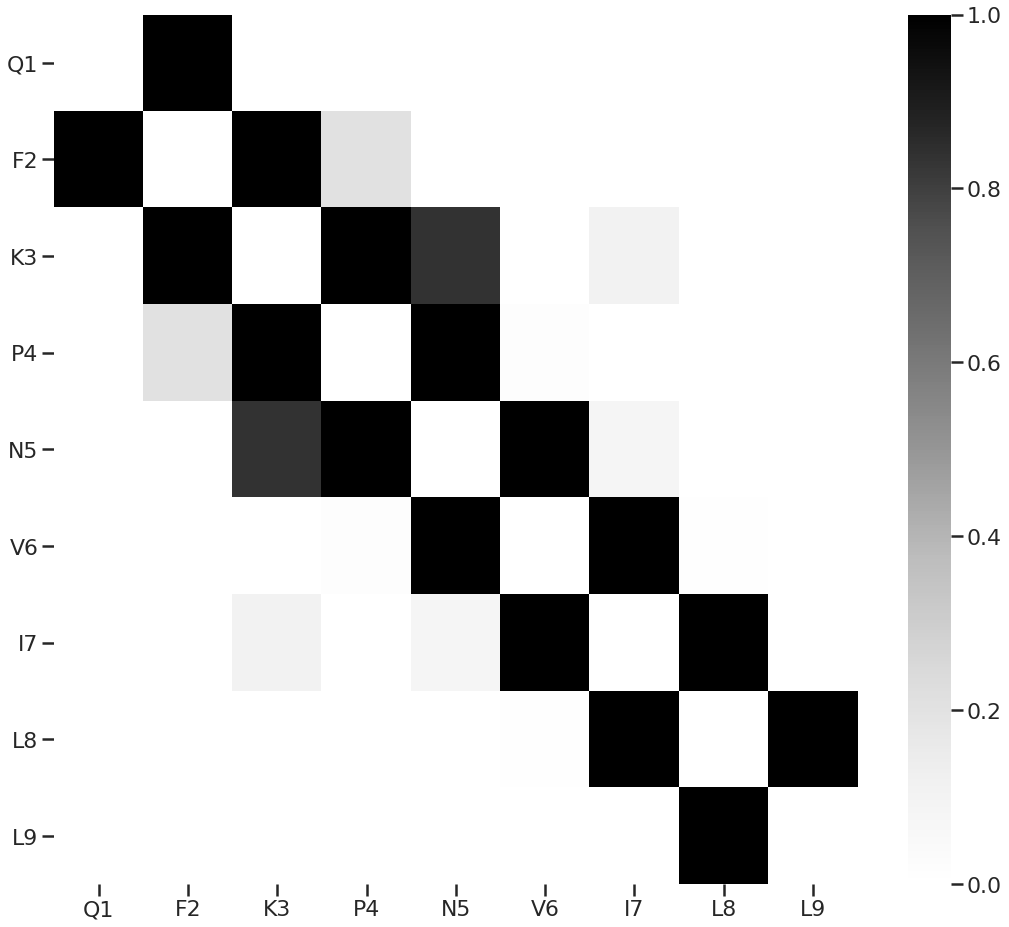

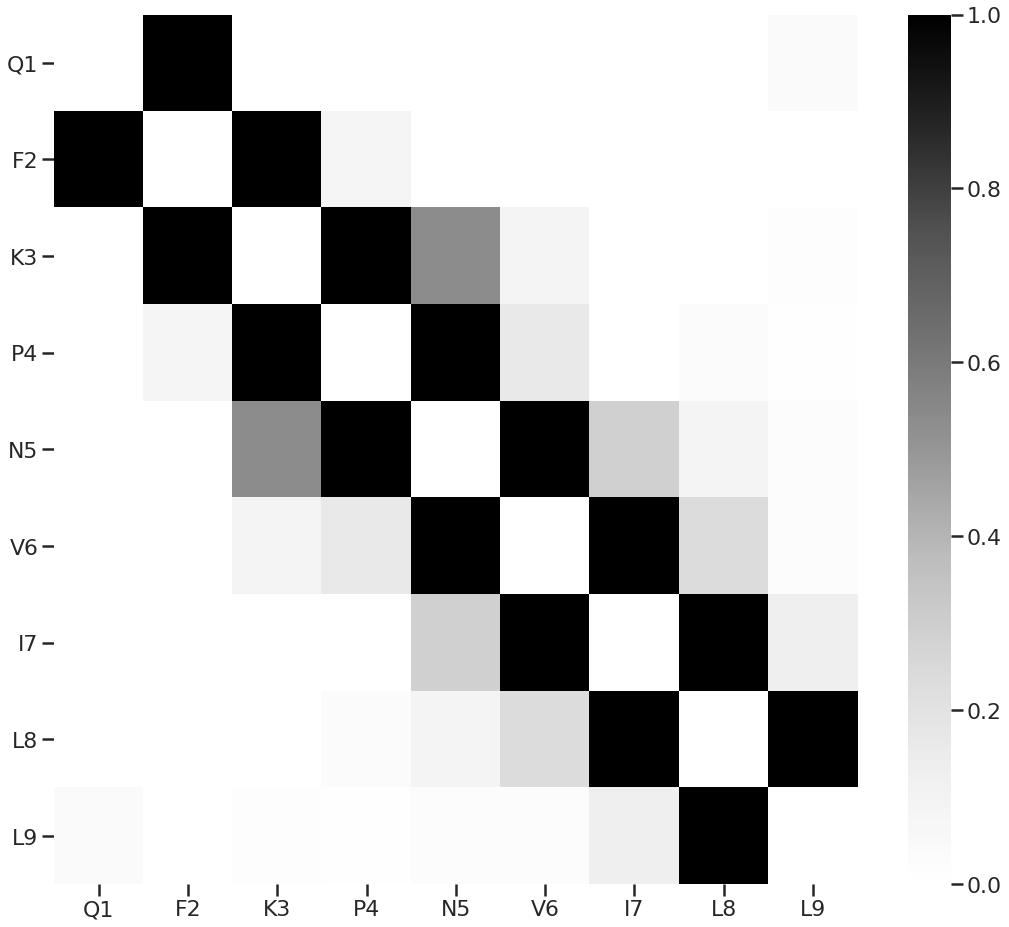

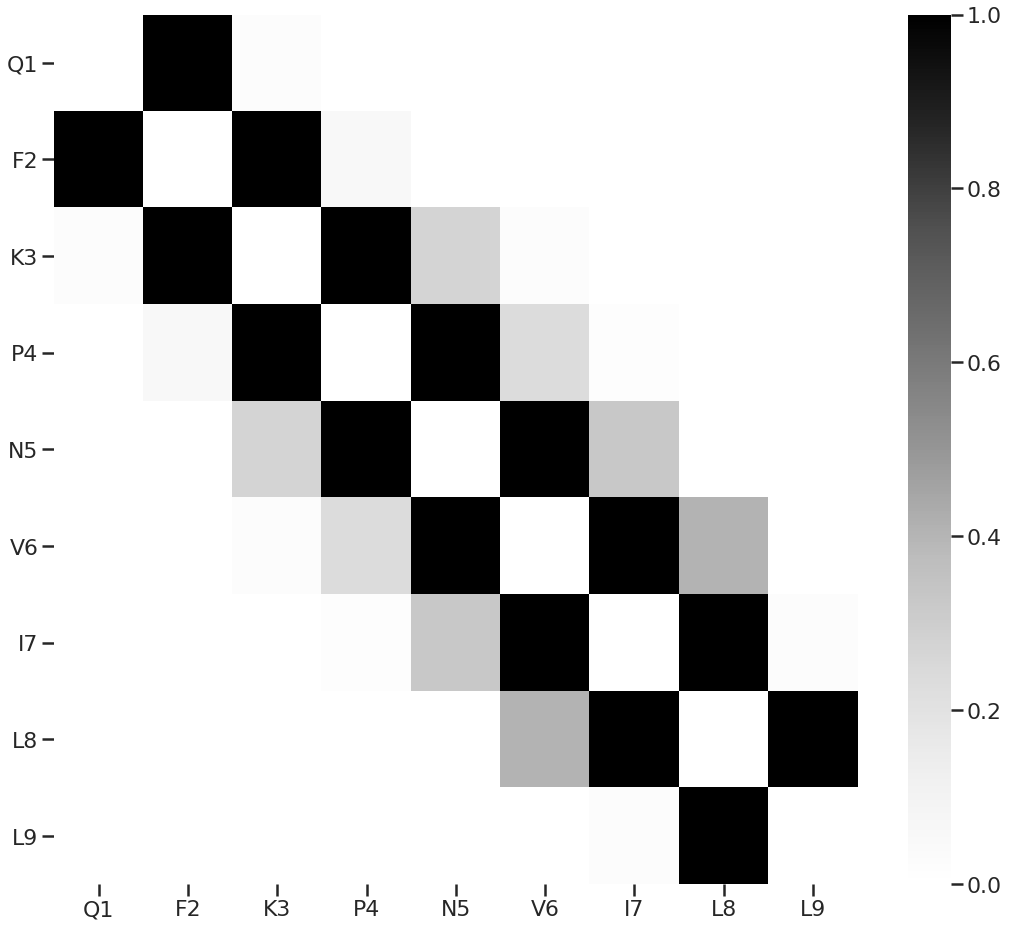

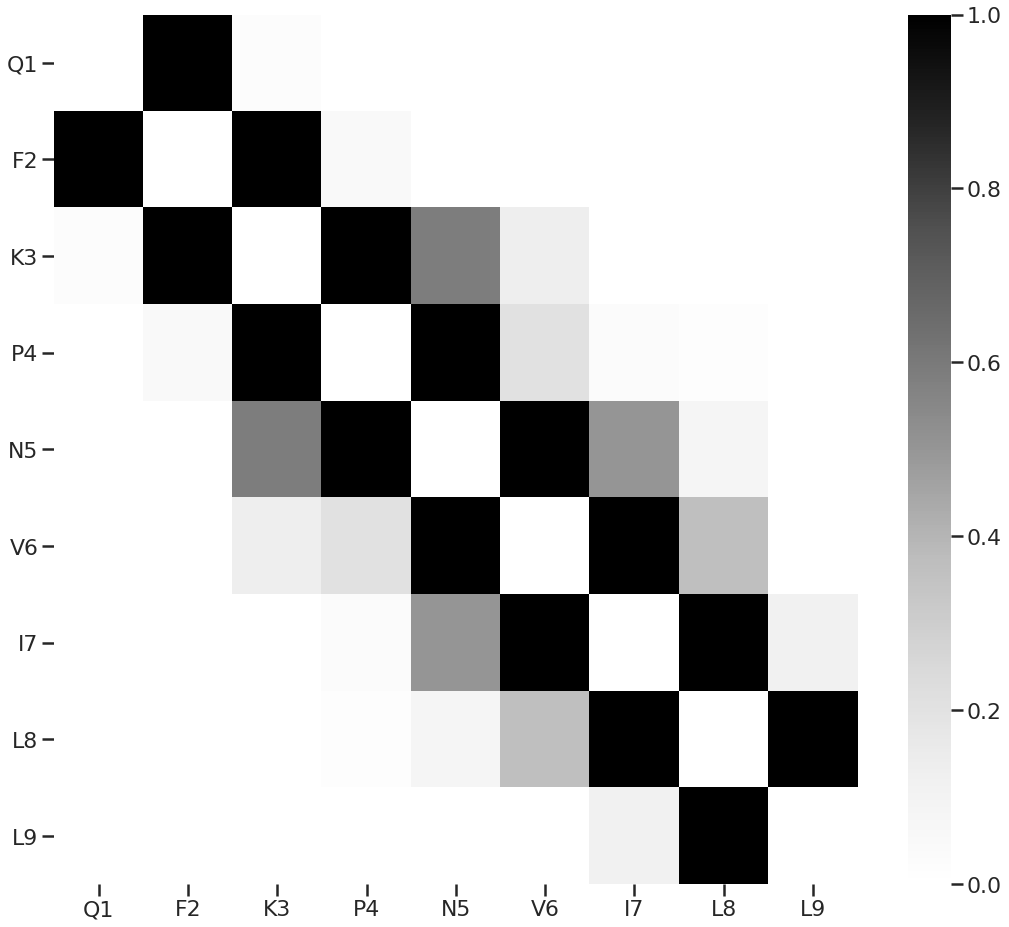

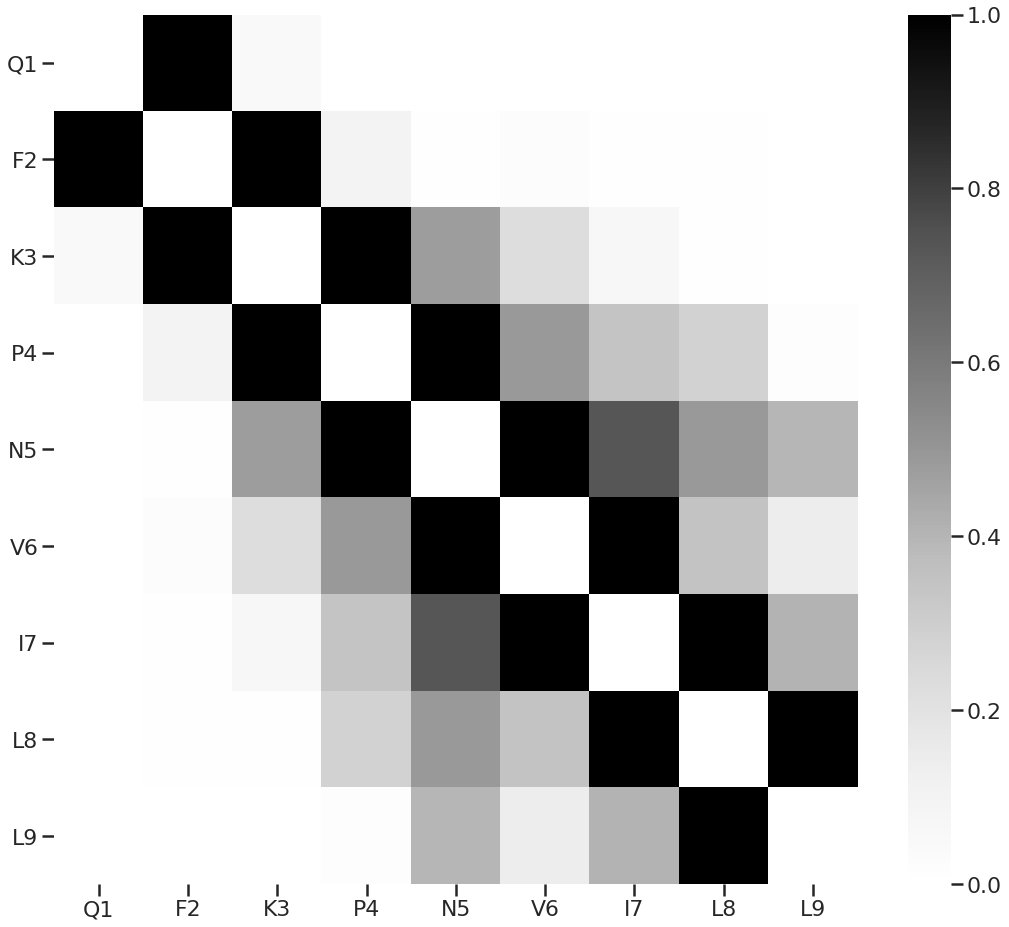

In [53]:
sns.set_context("poster")
one_letter_code = {'ARG':'R', 'HIS':'H', 'LYS':'K', 'ASP':'D', 'GLU':'E', \
                  'SER':'S', 'THR':'T', 'ASN':'N', 'GLN':'Q', 'CYS':'C', \
                  'GLY':'G', 'PRO':'P', 'ALA':'A', 'VAL':'V', 'ILE':'I', \
                  'LEU':'L', 'MET':'M', 'PHE':'F', 'TYR':'Y', 'TRP':'W'}
for i in range(5):
    fig = plt.figure(figsize=(18, 16))
    print("Macrostate", i)
    contacts_per_residue = [[] for j in range(9)]
    weights_per_residue = [[] for j in range(9)]
    interactions_per_residue = [np.zeros((9,)) for j in range(9)]
    mhc_res = ["" for j in range(9)]
    #mhc_toinclude = []
    for k in range(len(every_contact)):
        #if contact_macro_p_list[k][i] > 0.01: print(every_contact[k], contact_macro_p_list[k][i])
        resi_num = int(every_contact[k][3]) - 1
        mhc_num = int(every_contact[k][10:]) - 1
        mhc_label = every_contact[k][7:10]
        mhc_res[mhc_num] = one_letter_code[mhc_label] + str(mhc_num + 1)
        interactions_per_residue[resi_num][mhc_num] = contact_macro_p_list[k][i]
        contacts_per_residue[resi_num].append(every_contact[k])
        weights_per_residue[resi_num].append(contact_macro_p_list[k][i])
    for j in range(9):
        contacts_in_residue = np.array(contacts_per_residue[j])
        weights_in_residue = np.array(weights_per_residue[j])
        #print(j)
        sorted_indices = np.argsort(weights_in_residue)
        #print(contacts_in_residue[sorted_indices[-10:]], weights_in_residue[sorted_indices[-10:]])
        
    interactions = np.array(interactions_per_residue).T
    
    to_remove = []
    new_labels = []
    for j in range(len(interactions)):
        if np.sum(interactions[j]) < 0.01: to_remove.append(j)
        else: new_labels.append(mhc_res[j])
    interactions = np.delete(interactions, to_remove, 0)
    
    #print(interactions.shape)
    #cmap = sns.cubehelix_palette(as_cmap=True)
    sns.heatmap(interactions, cmap="Greys", vmin=0, vmax=1)
    #plt.xticks(np.arange(9)+0.5, ["Q1", "F2", "K3", "D4", "N5", "V6", "I7", "L8", "L9"])
    plt.xticks(np.arange(9)+0.5, ["Q1", "F2", "K3", "P4", "N5", "V6", "I7", "L8", "L9"])
    plt.yticks(np.arange(len(new_labels)) + 0.5, new_labels, rotation="horizontal")
    #plt.savefig('/home/jabella/Downloads/' + mode + '/contact_prob_macro' + str(i) + '.png', dpi=500)
    #break

In [54]:
# Compute contact probabilities between the peptide and MHC
if not os.path.exists("contact_prob.npz"):
    print("Computing contacts")
    is_contact = []
    for i in global_traj_indices:
        if i%10 == 0: print(i)
        i_str = str(i).zfill(4)    
        x = np.load(i_str + "/pep_to_MHC/Y.npy")
        #print(x.shape, x[:,pep_mhc_indices].shape)
        is_contact.append(x[:,pep_mhc_indices] < 0.35)

    print("Organizing")
    contacts_per_macrostate = [[] for i in range(5)]
    from collections import defaultdict
    contact_macro_p = defaultdict(lambda: np.zeros((5,)))
    for cluster_index in range(len(index_clusters)):
        print(cluster_index)
        if cluster_index not in active_set: continue
        MSM_cluster_index = np.where(active_set == cluster_index)[0][0]
        num_conf_in_cluster = len(index_clusters[cluster_index])
        conf_prob = (mu[MSM_cluster_index]/num_conf_in_cluster) / macro_p[state_to_macrostate[MSM_cluster_index]]
        for trajindex, frameindex in index_clusters[cluster_index]:
            all_contacts = feat_des[pep_mhc_indices][is_contact[trajindex][frameindex]]
            for c in all_contacts: contact_macro_p[c][state_to_macrostate[MSM_cluster_index]] += conf_prob
         
    every_contact = []
    contact_macro_p_list = []
    for k in contact_macro_p.keys():
        every_contact.append(k[25:])
        contact_macro_p_list.append(contact_macro_p[k])
        
    np.savez_compressed("contact_prob.npz", every_contact=every_contact, contact_macro_p_list=contact_macro_p_list)

else:
    every_contact = np.load("contact_prob.npz", allow_pickle=True)["every_contact"]
    contact_macro_p_list = np.load("contact_prob.npz", allow_pickle=True)["contact_macro_p_list"]

Macrostate 0
Macrostate 1
Macrostate 2
Macrostate 3


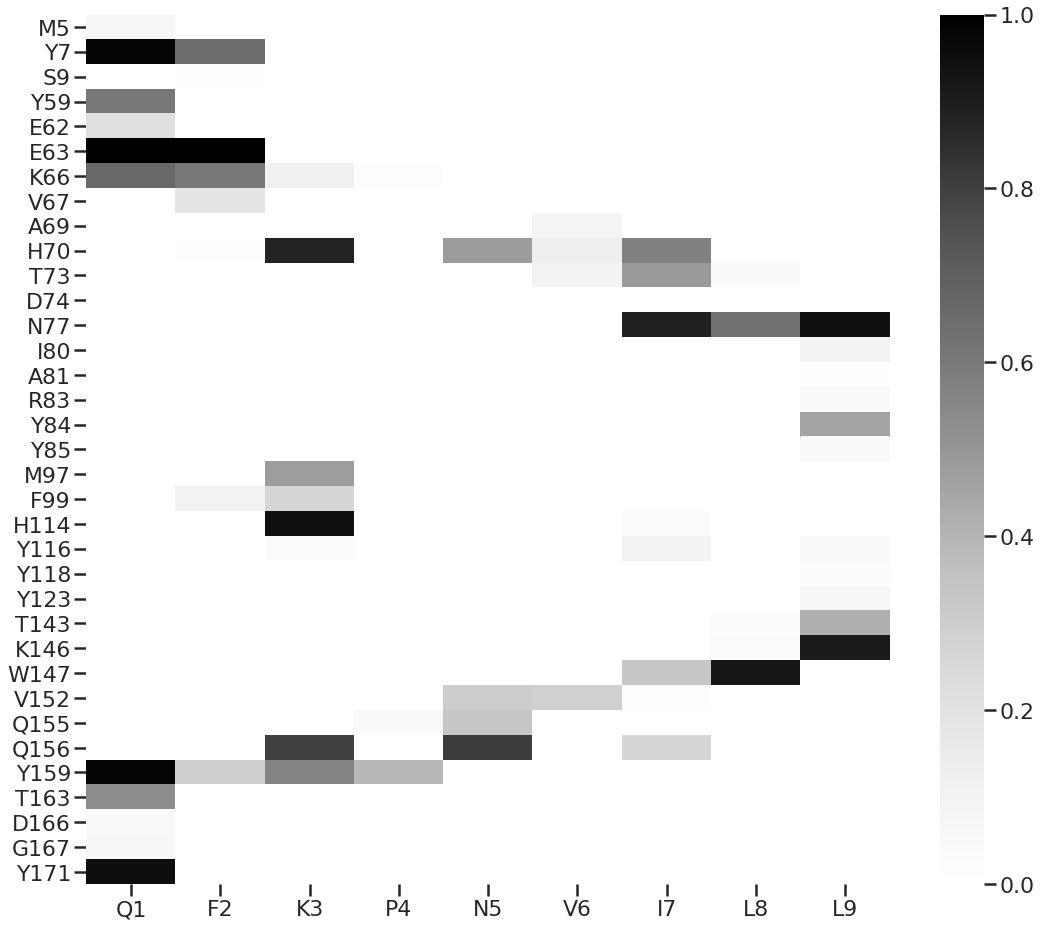

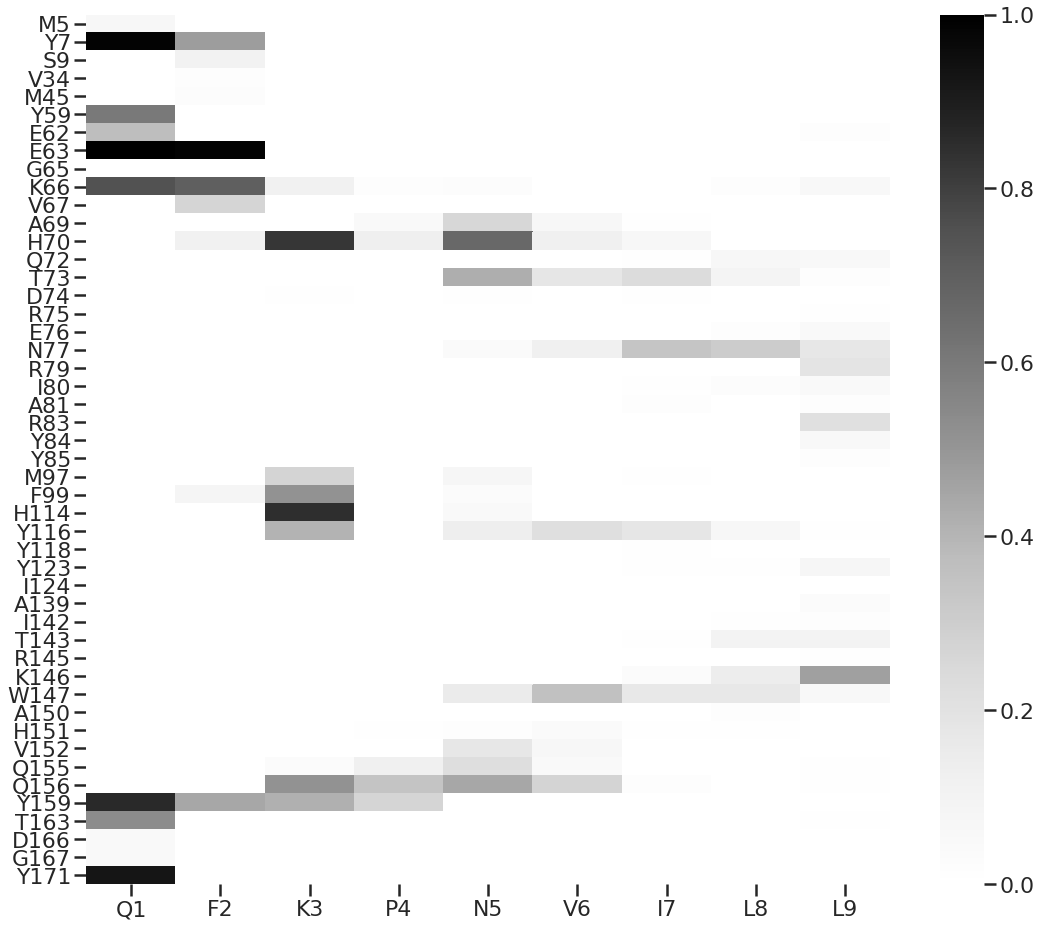

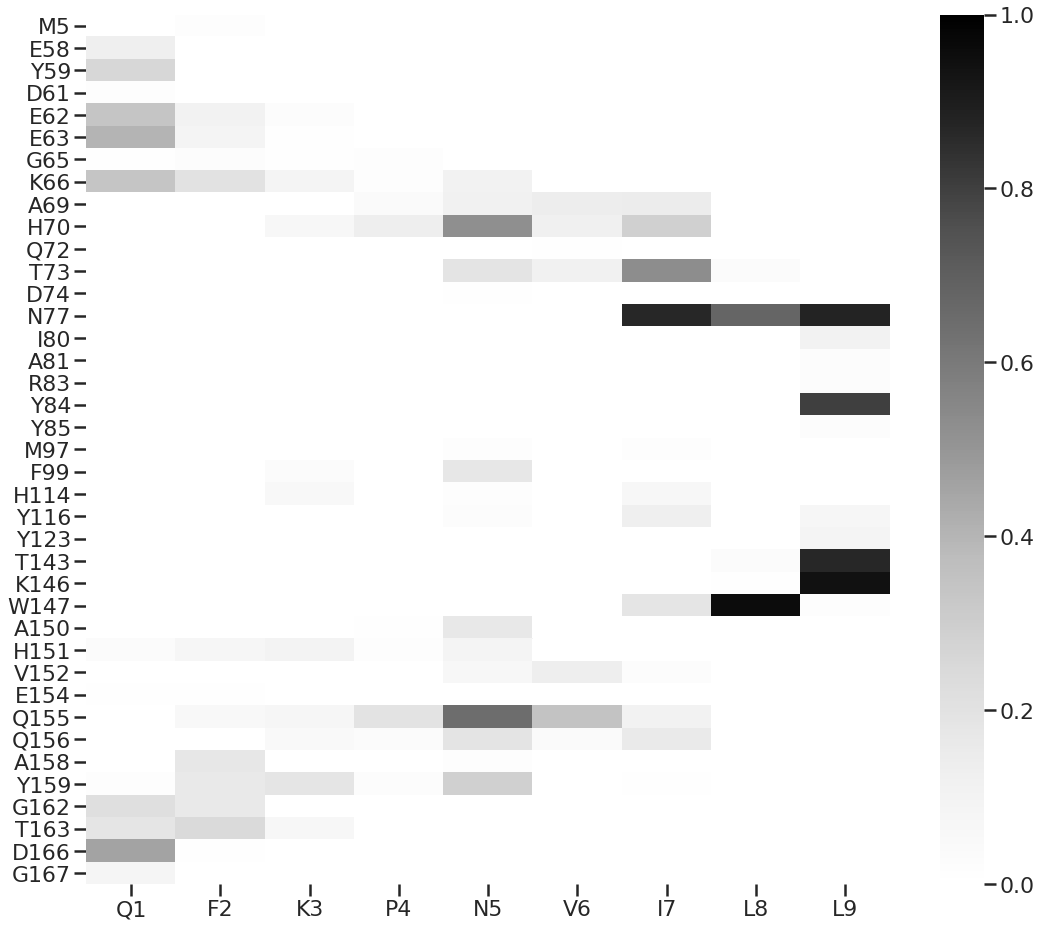

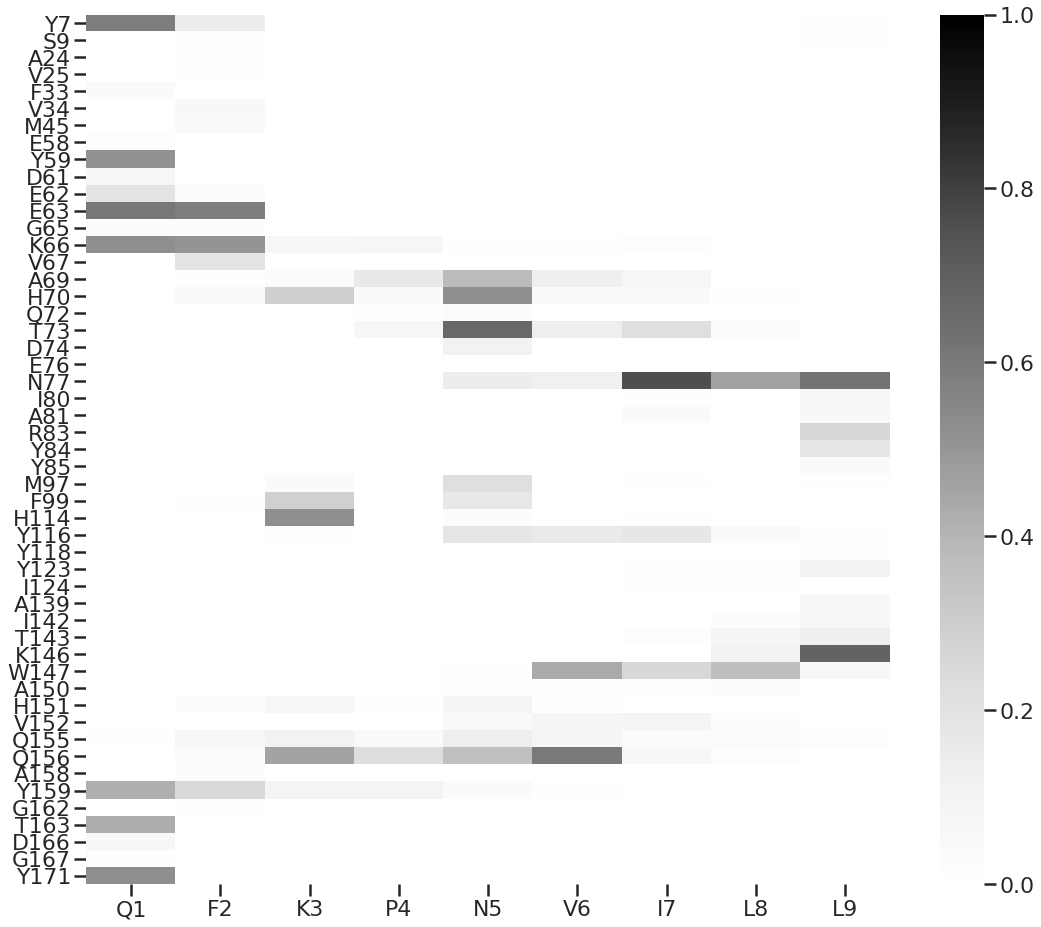

In [55]:
sns.set_context("poster")
one_letter_code = {'ARG':'R', 'HIS':'H', 'LYS':'K', 'ASP':'D', 'GLU':'E', \
                  'SER':'S', 'THR':'T', 'ASN':'N', 'GLN':'Q', 'CYS':'C', \
                  'GLY':'G', 'PRO':'P', 'ALA':'A', 'VAL':'V', 'ILE':'I', \
                  'LEU':'L', 'MET':'M', 'PHE':'F', 'TYR':'Y', 'TRP':'W'}
for i in range(4):
    fig = plt.figure(figsize=(18, 16))
    print("Macrostate", i)
    contacts_per_residue = [[] for j in range(9)]
    weights_per_residue = [[] for j in range(9)]
    interactions_per_residue = [np.zeros((180,)) for j in range(9)]
    mhc_res = ["" for j in range(180)]
    #mhc_toinclude = []
    for k in range(len(every_contact)):
        #if contact_macro_p_list[k][i] > 0.01: print(every_contact[k], contact_macro_p_list[k][i])
        resi_num = int(every_contact[k][3]) - 1
        mhc_num = int(every_contact[k][10:]) - 1
        mhc_label = every_contact[k][7:10]
        mhc_res[mhc_num] = one_letter_code[mhc_label] + str(mhc_num + 1)
        interactions_per_residue[resi_num][mhc_num] = contact_macro_p_list[k][i]
        contacts_per_residue[resi_num].append(every_contact[k])
        weights_per_residue[resi_num].append(contact_macro_p_list[k][i])
    for j in range(9):
        contacts_in_residue = np.array(contacts_per_residue[j])
        weights_in_residue = np.array(weights_per_residue[j])
        #print(j)
        sorted_indices = np.argsort(weights_in_residue)
        #print(contacts_in_residue[sorted_indices[-10:]], weights_in_residue[sorted_indices[-10:]])
        
    interactions = np.array(interactions_per_residue).T
    
    to_remove = []
    new_labels = []
    for j in range(len(interactions)):
        if np.sum(interactions[j]) < 0.01: to_remove.append(j)
        else: new_labels.append(mhc_res[j])
    interactions = np.delete(interactions, to_remove, 0)
    
    #print(interactions.shape)
    #cmap = sns.cubehelix_palette(as_cmap=True)
    sns.heatmap(interactions, cmap="Greys", vmin=0, vmax=1)
    #plt.xticks(np.arange(9)+0.5, ["Q1", "F2", "K3", "D4", "N5", "V6", "I7", "L8", "L9"])
    plt.xticks(np.arange(9)+0.5, ["Q1", "F2", "K3", "P4", "N5", "V6", "I7", "L8", "L9"])
    plt.yticks(np.arange(len(new_labels)) + 0.5, new_labels, rotation="horizontal")
    plt.savefig('pics/contact_prob_macro' + str(i) + '.png', dpi=500)
    #break

## Network Analysis

In [54]:
# get network of unbiased state
active_set = MSM.active_set
mu = MSM.stationary_distribution
nstates = MSM.nstates

# state definitions
unbound_states = []
associated_states = []
native_states = []
cterm_bound_states = []
nterm_bound_states = []
anchor_cutoff = 0.2
state_to_macrostate = []
print(nstates, len(active_set))
for MSM_state in range(nstates):
    cluster_index = active_set[MSM_state]
    nterm_rmsd, cterm_rmsd = cluster_feats_rmsd[cluster_index]
    #if nterm_rmsd < anchor_cutoff and cterm_rmsd < anchor_cutoff: native_states.append(MSM_state)
    if cluster_feats_r[cluster_index] < 0.2: 
        native_states.append(MSM_state)
        state_to_macrostate.append(0)
    elif nterm_rmsd >= anchor_cutoff and cterm_rmsd < anchor_cutoff: 
        cterm_bound_states.append(MSM_state)
        state_to_macrostate.append(2)
    elif nterm_rmsd < anchor_cutoff and cterm_rmsd >= anchor_cutoff: 
        nterm_bound_states.append(MSM_state)
        state_to_macrostate.append(1)
    #elif cluster_index == len(index_clusters) - 1: unbound_states.append(MSM_state)
    elif cluster_feats[cluster_index] > 0.5: 
        unbound_states.append(MSM_state)
        state_to_macrostate.append(4)
    else: 
        associated_states.append(MSM_state)
        state_to_macrostate.append(3)
#print(unbound_states, native_states, cterm_bound_states, nterm_bound_states)
print(len(unbound_states))

100 100
21


In [55]:
# plot network
mfpt = np.zeros((5, 5))
metastable_sets = [native_states,nterm_bound_states,cterm_bound_states,associated_states,unbound_states]
bound_states = native_states+nterm_bound_states+cterm_bound_states+associated_states
for i in range(5):
    for j in range(5):
        mfpt[i, j] = steps_to_nanoseconds*(1/1E6)*MSM.mfpt(
            metastable_sets[i],
            metastable_sets[j])
        #if i == j:
        #    mfpt[i,j] = 0
        #    continue
        #mfpt[i,j] = pyemma.msm.tpt(MSM, metastable_sets[i], metastable_sets[j]).flux

mfpt[3,4] = steps_to_nanoseconds*(1/1E6)*MSM.mfpt(bound_states, unbound_states)
mfpt[4,3] = steps_to_nanoseconds*(1/1E6)*MSM.mfpt(unbound_states, bound_states)

        
inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]

#inverse_mfpt[inverse_mfpt > 0.01] = 1.0
#inverse_mfpt[inverse_mfpt < 0.01] = 0.1

inverse_mfpt[0,3] = 0
inverse_mfpt[0,4] = 0
inverse_mfpt[1,2] = 0
inverse_mfpt[1,4] = 0
inverse_mfpt[2,1] = 0
inverse_mfpt[2,4] = 0
inverse_mfpt[3,0] = 0
inverse_mfpt[4,0] = 0
inverse_mfpt[4,1] = 0
inverse_mfpt[4,2] = 0

#print(inverse_mfpt)
#print(mfpt)

In [56]:
print(MSM.nstates, MSM.stationary_distribution.shape, MSM.active_set.shape)
MSM.stationary_distribution = MSM.stationary_distribution[MSM.active_set] / np.sum(MSM.stationary_distribution[MSM.active_set])


100 (100,) (100,)


In [57]:
print(macro_p)

[0.5735395146922192, 0.1348714707482288, 0.2542638272543921, 0.01057597950135608, 0.02674920780380378]


(100, 100)
[[0.         0.         1.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.61306414 0.38693448]
 [0.         0.         0.         0.         0.61306547]
 [0.         0.         0.         0.         0.        ]]


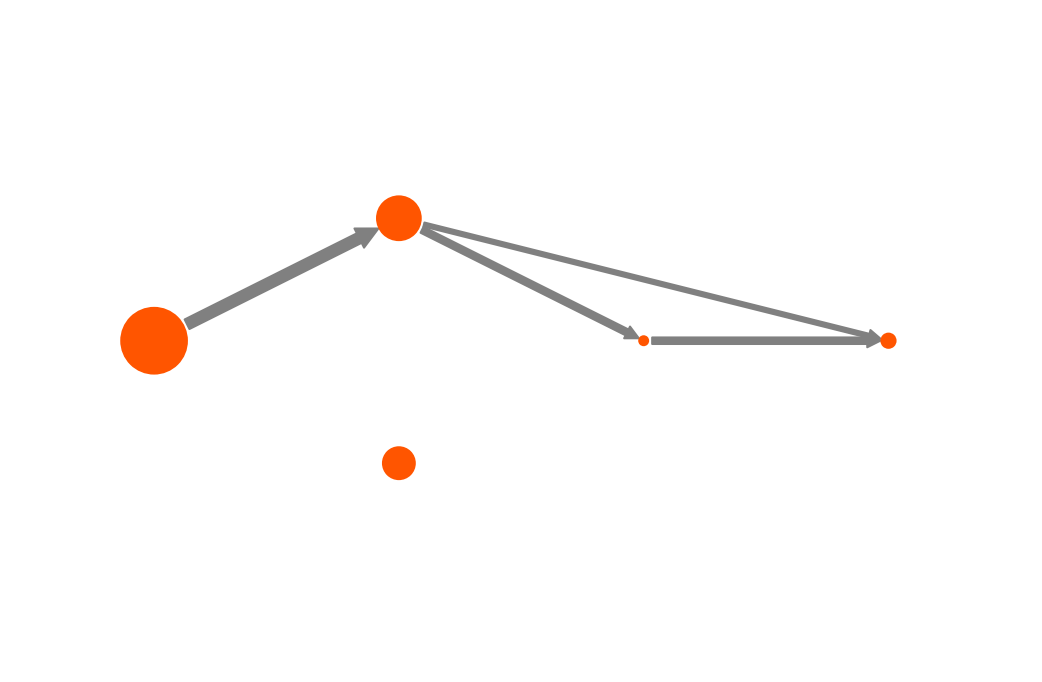

In [58]:
t = pyemma.msm.tpt(MSM, native_states, unbound_states)
#t = pyemma.msm.tpt(MSM, unbound_states, native_states)
print(t.flux.shape)
cg, cgflux = t.coarse_grain(metastable_sets)

#cgflux.flux /= np.sum(cgflux.flux[0])
#print(cgflux.flux)
print(1.0/np.sum(cgflux.flux[0,:]) * cgflux.flux)
fig, ax = plt.subplots(figsize=(15, 10))
macro_p_visual = np.array(macro_p)
macro_p = np.array(macro_p)
pyemma.plots.plot_flux(cgflux, flux_scale=1.0/np.sum(cgflux.flux[0,:]), pos=np.array([(0,0),(1,-0.5),(1,0.5),(2,0),(3,0)]), 
                       show_committor=False, ax=ax, arrow_labels=None, arrow_curvature=0.0,
                      state_labels=None, state_sizes=macro_p, minflux=0.0001,
                      size=20) #state_colors='#d9dddc', 

fij = 100.0/np.sum(cgflux.flux[0,:]) * cgflux.flux

fig.tight_layout()

#plt.savefig('pics/unbind.png')
plt.savefig('pics/unbind_hires.png', dpi=500)

## Mutational Analysis

In [2]:
bound_states = associated_states + native_states + cterm_bound_states + nterm_bound_states

#bound_states = native_states
dG = RT*np.log(np.sum(mu[unbound_states]) / np.sum(mu[bound_states]))
dG_muts = []
metastable_ddGs = []
for mutant in ["Q1", "F2", "K3", "D4", "N5", "V6", "I7", "L8", "L9"]: #["Q155", "Y159"]: # Change to reflect mutations
    metastable_prob_wild = np.zeros((5,))
    metastable_prob_mut = np.zeros((5,))

    Z_wild_bound = 0
    Z_wild_unbound = 0
    Z_mut_bound = 0
    Z_mut_unbound = 0
    beta = 1. / RT
    num_confs_per_cluster = [len(ic) for ic in index_clusters]
    dEnergy = []
    for i, traj in enumerate(dtrajs):
        global_traj_index = global_traj_indices[i]

        wild_energies = []
        f = open(str(global_traj_index).zfill(4) + "/energies/wild.txt", 'r')
        for line in f:
            line_arr = line.split()
            wild_energies.append(float(line_arr[0]))
            #if float(line_arr[0]) > 0: print float(line_arr[0])
        f.close()

        mut_energies = []
        f = open(str(global_traj_index).zfill(4) + "/energies/" + mutant + ".txt", 'r')
        for line in f:
            line_arr = line.split()
            mut_energies.append(float(line_arr[0]))
        f.close()
        cluster_assignments_in_traj = traj[::25]
        #if len(traj)-len(mut_energies) == 1: cluster_assignments_in_traj = cluster_assignments_in_traj[:-1]

        wild_energies = np.array(wild_energies)
        mut_energies = np.array(mut_energies)
        #print(i, wild_energies.shape, mut_energies.shape)

        for j,cluster_index in enumerate(cluster_assignments_in_traj):
            if cluster_index not in active_set: continue

            MSM_cluster_index = np.where(active_set == cluster_index)[0][0]
            wild_val = mu[MSM_cluster_index] / num_confs_per_cluster[cluster_index]
            reweighting_factor = np.exp( beta * (wild_energies[j] - mut_energies[j]) )

            if np.isinf(reweighting_factor): 
                print(i, j, cluster_index, wild_energies[j], mut_energies[j])
                continue

            dEnergy.append(wild_energies[j] - mut_energies[j])

            mut_val = reweighting_factor*wild_val
            if MSM_cluster_index in bound_states:
                Z_wild_bound += wild_val
                Z_mut_bound += mut_val
            elif MSM_cluster_index in unbound_states:
                Z_wild_unbound += wild_val
                Z_mut_unbound += mut_val

            metastable_prob_wild[state_to_macrostate[MSM_cluster_index]] += wild_val
            metastable_prob_mut[state_to_macrostate[MSM_cluster_index]] += mut_val


    #print(Z_wild_bound, Z_wild_unbound)
    #print(Z_mut_bound, Z_mut_unbound)
    #print(Z_wild_bound / Z_wild_unbound, Z_mut_unbound / Z_mut_bound, (Z_wild_bound / Z_wild_unbound) * (Z_mut_unbound / Z_mut_bound))
    #print(Z_wild_unbound / Z_wild_bound, Z_mut_unbound / Z_mut_bound)
    #print(RT*np.log( (Z_wild_unbound / Z_wild_bound)))
    ddG = RT*np.log( (Z_wild_bound / Z_wild_unbound) * (Z_mut_unbound / Z_mut_bound) )
    dG_mut = RT*np.log(Z_mut_unbound / Z_mut_bound)
    dG_wild = RT*np.log(Z_wild_unbound / Z_wild_bound)

    if dG_mut > 0: outputlabel = "weaker binder, non binder"
    elif abs(ddG) < 0.1: outputlabel = "similar binder"
    elif dG_wild < dG_mut: outputlabel = "weaker binder"
    elif dG_wild > dG_mut: outputlabel = "stronger binder"
    else: outputlabel = "nan"
    print(mutant, ddG, outputlabel)
    print(ddG, dG, dG_wild, dG_mut)
    #print(Z_wild_bound, Z_wild_unbound)
    #print(metastable_prob_wild)
    #print(Z_mut_bound, Z_mut_unbound)
    #print(metastable_prob_mut)
    metastable_ddGs_mut = RT*np.log( (metastable_prob_wild / Z_wild_unbound) * (Z_mut_unbound / metastable_prob_mut) )
    metastable_ddGs.append(metastable_ddGs_mut)
    print(metastable_ddGs_mut)
    dG_muts.append(dG_mut)

In [38]:
f = open("pics/metastable_ddGs.csv", 'w')
metastable_ddGs = np.array(metastable_ddGs)
print(metastable_ddGs.shape)
labels = ["Macrostate","Q1", "F2", "K3", "D4", "N5", "V6", "I7", "L8", "L9"]
print(",".join(labels))
f.write(",".join(labels))
f.write("\n")
for i in range(4):
    mddGs_str = [str(i)] + ["%.1f"%g for g in metastable_ddGs[:,i]]
    print(",".join(mddGs_str))
    f.write(",".join(mddGs_str))
    f.write("\n")
f.close()

(9, 5)
Macrostate,Q1,F2,K3,D4,N5,V6,I7,L8,L9
0,29.7,38.7,18.8,14.9,5.5,1.5,7.7,-0.1,19.8
1,34.0,37.7,-8.5,17.5,5.8,0.4,-2.9,-3.0,1.1
2,-2.9,7.3,-8.1,3.5,13.0,3.3,9.7,-1.0,15.9
3,-0.2,6.7,-2.2,4.6,7.5,-0.0,7.3,4.8,8.7


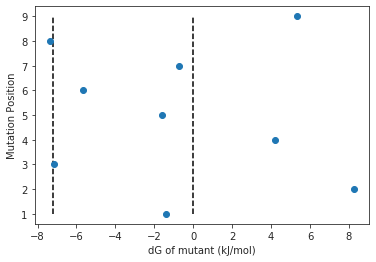

In [39]:
mutants = ["Q1", "F2", "K3", "D4", "N5", "V6", "I7", "L8", "L9"]
X = []
xerrs = []
Y = []
for i,mut in enumerate(dG_muts):
    X.append(np.mean(mut))
    xerrs.append(np.std(mut))
    Y.append(i+1)
plt.errorbar(X,Y, xerr=xerrs, fmt="o")
plt.plot(9*[dG], np.arange(1,10), "--", c="black")
plt.plot(9*[0], np.arange(1,10), "--", c="black")
plt.xlabel("dG of mutant (kJ/mol)")
plt.ylabel("Mutation Position")
plt.savefig('pics/ddG_newdata.png', dpi=1200)

In [40]:
#nstates = 8
bound_states = associated_states + native_states + cterm_bound_states + nterm_bound_states

#bound_states = native_states
dG = RT*np.log(np.sum(mu[unbound_states]) / np.sum(mu[bound_states]))
dG_muts = []
dEnergy = {}
for mutant in ["Q1", "F2", "K3", "D4", "N5", "V6", "I7", "L8", "L9"]: 
    dEnergy[mutant] = [[] for _ in range(len(mu))]
for mutant in ["Q1", "F2", "K3", "D4", "N5", "V6", "I7", "L8", "L9"]:

    for i, traj in enumerate(dtrajs):
        global_traj_index = global_traj_indices[i]
        
        wild_energies = []
        f = open(str(global_traj_index).zfill(4) + "/energies/wild.txt", 'r')
        for line in f:
            line_arr = line.split()
            wild_energies.append(float(line_arr[0]))
            #if float(line_arr[0]) > 0: print float(line_arr[0])
        f.close()
        
        mut_energies = []
        f = open(str(global_traj_index).zfill(4) + "/energies/" + mutant + ".txt", 'r')
        for line in f:
            line_arr = line.split()
            mut_energies.append(float(line_arr[0]))
        f.close()
        cluster_assignments_in_traj = traj[::25]
        #if len(traj)-len(mut_energies) == 1: cluster_assignments_in_traj = cluster_assignments_in_traj[:-1]

        wild_energies = np.array(wild_energies)
        mut_energies = np.array(mut_energies)

        for j,cluster_index in enumerate(cluster_assignments_in_traj):
            if cluster_index not in active_set: continue

            MSM_cluster_index = np.where(active_set == cluster_index)[0][0]
            #wild_val = mu[MSM_cluster_index] / num_confs_per_cluster[cluster_index]
            reweighting_factor = np.exp( beta * (wild_energies[j] - mut_energies[j]) )
            
            dEnergy[mutant][MSM_cluster_index].append(reweighting_factor)
            

for mutant in ["Q1", "F2", "K3", "D4", "N5", "V6", "I7", "L8", "L9"]: 
    dEnergy[mutant] = np.array(dEnergy[mutant])           
print(dEnergy["Q1"].shape)

(100,)


In [41]:
N = 5000
dG_muts = []
for mutant in ["Q1", "F2", "K3", "D4", "N5", "V6", "I7", "L8", "L9"]:
    dG_mut_sample = []
    for i in range(10):
        Z_wild_bound = 0
        Z_wild_unbound = 0
        Z_mut_bound = 0
        Z_mut_unbound = 0
        beta = 1. / RT
        for MSM_cluster_index in range(len(mu)):
            wild_val = mu[MSM_cluster_index]
            vals_in_cluster = np.array(dEnergy[mutant][MSM_cluster_index])
            random_subset = np.random.choice(vals_in_cluster, size=N, replace=True)
            reweighting_factor = np.mean(random_subset)
            mut_val = reweighting_factor*wild_val
            if MSM_cluster_index in bound_states:
                Z_wild_bound += wild_val
                Z_mut_bound += mut_val
            elif MSM_cluster_index in unbound_states:
                Z_wild_unbound += wild_val
                Z_mut_unbound += mut_val

        ddG = RT*np.log( (Z_wild_bound / Z_wild_unbound) * (Z_mut_unbound / Z_mut_bound) )
        dG_mut = RT*np.log(Z_mut_unbound / Z_mut_bound)
        dG_wild = RT*np.log(Z_wild_unbound / Z_wild_bound)

        #if dG_mut > 0: outputlabel = "weaker binder, non binder"
        #elif abs(ddG) < 0.1: outputlabel = "similar binder"
        #elif dG_wild < dG_mut: outputlabel = "weaker binder"
        #elif dG_wild > dG_mut: outputlabel = "stronger binder"
        #else: outputlabel = "nan"
        #print(mutant, ddG, outputlabel)
        #print(ddG, dG, dG_wild, dG_mut)
        dG_mut_sample.append(dG_mut)
    dG_muts.append(dG_mut_sample)

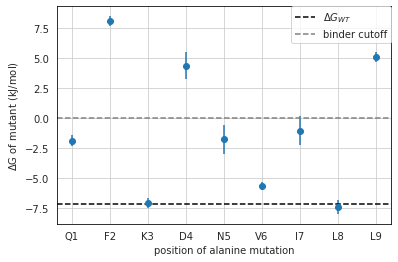

In [78]:
sns.set_style("whitegrid", {"axes.edgecolor": "0.0"})
mutants = ["Q1", "F2", "K3", "D4", "N5", "V6", "I7", "L8", "L9"]
X = []
yerrs = []
Y = []
for i,mut in enumerate(dG_muts):
    Y.append(np.mean(mut))
    yerrs.append(np.std(mut))
    #X.append(i+1)
    X.append(mutants[i])
plt.errorbar(X,Y, yerr=yerrs, fmt="o")
#plt.plot(11*[dG], [0.5] + [i for i in range(1,10)] + [9.5], "--", c="black")
#plt.plot(11*[0], [0.5] + [i for i in range(1,10)] + [9.5], "--", c="black")
plt.axhline(y=dG, xmin=0, xmax=1, c="black", linestyle="--", label="$\Delta G_{WT}$")
plt.axhline(y=0, xmin=0, xmax=1, c="gray", linestyle="--", label="binder cutoff")
plt.ylabel("$\Delta$G of mutant (kJ/mol)")
plt.xlabel("position of alanine mutation")
plt.legend(loc='upper right', borderaxespad=0.)
plt.savefig('pics/ddG.png', dpi=500)

## Bootstrap
Please run `bootstrap_us.py` before executing the following code

In [59]:
# Setup CK test

# to compute P_MSM
# for all bootstraps in msm obj with lag 250*25
# for every macrostate, for every macrostate
# compute w^A
# propagate by right multipling with (fractional) power of T 
# save prob of transition
# if lag 0, self is 1 and other is 0

from collections import defaultdict
data_frames = defaultdict(lambda: {'Lags':[], 'Probability':[], 'Order':[]})

print("Computing prediction")    
for b in range(100):
    us = pyemma.load("bootstrap/us_obj_" + str(us_lag) + "_" + str(b),"us_obj")
    MSM = pyemma.load("bootstrap/msm_obj_" + str(us_lag) + "_" + str(b),"msm_obj")
    
    active_set = MSM.active_set
    mu = MSM.stationary_distribution
    nstates = MSM.nstates
    
    # state definitions
    unbound_states = []
    associated_states = []
    native_states = []
    cterm_bound_states = []
    nterm_bound_states = []
    anchor_cutoff = 0.2
    state_to_macrostate = []
    for MSM_state in range(nstates):
        cluster_index = active_set[MSM_state]
        nterm_rmsd, cterm_rmsd = cluster_feats_rmsd[cluster_index]
        if cluster_feats_r[cluster_index] < 0.2: 
            native_states.append(MSM_state)
            state_to_macrostate.append(0)
        elif nterm_rmsd >= anchor_cutoff and cterm_rmsd < anchor_cutoff: 
            cterm_bound_states.append(MSM_state)
            state_to_macrostate.append(2)
        elif nterm_rmsd < anchor_cutoff and cterm_rmsd >= anchor_cutoff: 
            nterm_bound_states.append(MSM_state)
            state_to_macrostate.append(1)
        elif cluster_feats[cluster_index] > 0.5: 
            unbound_states.append(MSM_state)
            state_to_macrostate.append(4)
        else: 
            associated_states.append(MSM_state)
            state_to_macrostate.append(3)
  
    macrostates = [native_states, nterm_bound_states, cterm_bound_states, associated_states, unbound_states]
    skipBootstrap = False
    for macrostate in macrostates:
        if len(macrostate) == 0: skipBootstrap = True
    if skipBootstrap: continue
    macro_p = [np.sum(mu[native_states]), np.sum(mu[nterm_bound_states]), np.sum(mu[cterm_bound_states]), np.sum(mu[associated_states]), np.sum(mu[unbound_states])]
    
    for i in range(5):
        # define initial weight vector for macrostate i
        w_i = np.zeros((1,nstates))
        w_i[0, macrostates[i]] = mu[macrostates[i]] / macro_p[i]
        for j in range(5):
            
            macro_transition = str(i) + "-" + str(j)
            data_frame = data_frames[macro_transition]
            
            data_frame["Lags"].append(0)
            data_frame["Probability"].append(int(i == j))
            data_frame["Order"].append("Predict")
            
            data_frame["Lags"].append(us_lag_ns)
            lagged_dist = np.matmul(w_i, MSM.P)
            data_frame["Probability"].append(np.sum(lagged_dist[0,macrostates[j]]))
            data_frame["Order"].append("Predict")
            
            data_frame["Lags"].append(us_lag_ns*2)
            lagged_dist = np.matmul(lagged_dist, MSM.P)
            data_frame["Probability"].append(np.sum(lagged_dist[0,macrostates[j]]))
            data_frame["Order"].append("Predict")

# to compute P_MD
# for all lags, for all bootstraps
# for every macrostate, for every macrostate
# compute w^A
# propagate with already computed T
# save prob of transition
print("Computing estimate")
lags = [0, us_lag, us_lag*2]
for lag in lags:
    if lag == 0:
        
        for b in range(100):
            for i in range(5):
                for j in range(5):

                    macro_transition = str(i) + "-" + str(j)
                    data_frame = data_frames[macro_transition]

                    data_frame["Lags"].append(0)
                    data_frame["Probability"].append(int(i == j))
                    data_frame["Order"].append("Estimate")
        continue
        
    for b in range(100):
        us = pyemma.load("bootstrap/us_obj_" + str(lag) + "_" + str(b),"us_obj")
        MSM = pyemma.load("bootstrap/msm_obj_" + str(lag) + "_" + str(b),"msm_obj")

        active_set = MSM.active_set
        mu = MSM.stationary_distribution
        nstates = MSM.nstates

        # state definitions
        unbound_states = []
        associated_states = []
        native_states = []
        cterm_bound_states = []
        nterm_bound_states = []
        anchor_cutoff = 0.2
        state_to_macrostate = []
        for MSM_state in range(nstates):
            cluster_index = active_set[MSM_state]
            nterm_rmsd, cterm_rmsd = cluster_feats_rmsd[cluster_index]
            if cluster_feats_r[cluster_index] < 0.2: 
                native_states.append(MSM_state)
                state_to_macrostate.append(0)
            elif nterm_rmsd >= anchor_cutoff and cterm_rmsd < anchor_cutoff: 
                cterm_bound_states.append(MSM_state)
                state_to_macrostate.append(2)
            elif nterm_rmsd < anchor_cutoff and cterm_rmsd >= anchor_cutoff: 
                nterm_bound_states.append(MSM_state)
                state_to_macrostate.append(1)
            elif cluster_feats[cluster_index] > 0.5: 
                unbound_states.append(MSM_state)
                state_to_macrostate.append(4)
            else: 
                associated_states.append(MSM_state)
                state_to_macrostate.append(3)
      
        macrostates = [native_states, nterm_bound_states, cterm_bound_states, associated_states, unbound_states]
        skipBootstrap = False
        for macrostate in macrostates:
            if len(macrostate) == 0: skipBootstrap = True
        if skipBootstrap: continue
        macro_p = [np.sum(mu[native_states]), np.sum(mu[nterm_bound_states]), np.sum(mu[cterm_bound_states]), np.sum(mu[associated_states]), np.sum(mu[unbound_states])]

        for i in range(5):
            # define initial weight vector for macrostate i
            w_i = np.zeros((1,nstates))
            w_i[0, macrostates[i]] = mu[macrostates[i]] / macro_p[i]
            for j in range(5):

                macro_transition = str(i) + "-" + str(j)
                data_frame = data_frames[macro_transition]

                data_frame["Lags"].append(lag * steps_to_nanoseconds)
                lagged_dist = np.matmul(w_i, MSM.P)
                data_frame["Probability"].append(np.sum(lagged_dist[0,macrostates[j]]))
                data_frame["Order"].append("Estimate")




Computing prediction
Computing estimate


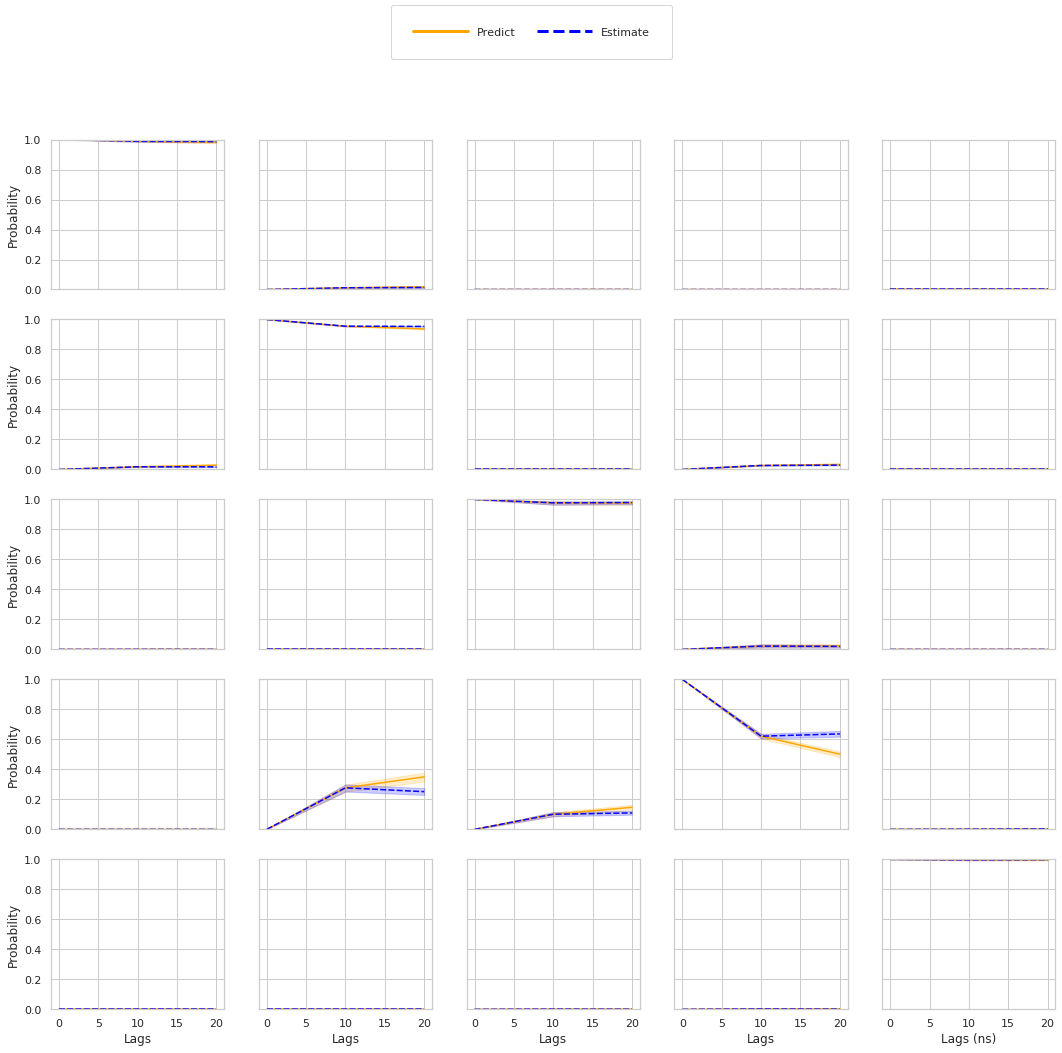

In [60]:
sns.set_context("notebook")
sns.set_style("whitegrid")
fig, axs = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(18, 16))
for i in range(5):
    for j in range(5):
        df = pd.DataFrame(data_frames[str(i) + "-" + str(j)])
        sns.lineplot(x='Lags', y="Probability", data=df, hue="Order", style="Order", legend=False, ax=axs[i,j], palette=["orange", "blue"])

#plt.xlim([0,500])
plt.ylim([0,1])
#plt.yscale("log")
plt.xlabel("Lags (ns)")
#plt.ylabel("Probability")
#plt.legend()
from matplotlib.lines import Line2D

colors = ['orange', 'blue']
lines = [Line2D([0], [0], color="orange", linewidth=3, linestyle='-'), Line2D([0], [0], color="blue", linewidth=3, linestyle='--')]
labels = ['Predict', 'Estimate']
fig.legend(lines, labels, loc='upper center', borderpad=2, ncol=2, handlelength=5)
plt.savefig('pics/ckplot.png', dpi=500)

In [69]:
# bootstrap estimate of dG of binding
dG_boot = []
for b in range(100):
    us = pyemma.load("bootstrap/us_obj_" + str(us_lag) + "_" + str(b),"us_obj")
    MSM = pyemma.load("bootstrap/msm_obj_" + str(us_lag) + "_" + str(b),"msm_obj")

    active_set = us.active_set
    mu = us.stationary_distribution
    nstates = us.nstates

    # state definitions
    unbound_states = []
    associated_states = []
    native_states = []
    cterm_bound_states = []
    nterm_bound_states = []
    anchor_cutoff = 0.2
    state_to_macrostate = []
    for MSM_state in range(nstates):
        cluster_index = active_set[MSM_state]
        nterm_rmsd, cterm_rmsd = cluster_feats_rmsd[cluster_index]
        if cluster_feats_r[cluster_index] < 0.2: 
            native_states.append(MSM_state)
            state_to_macrostate.append(0)
        elif nterm_rmsd >= anchor_cutoff and cterm_rmsd < anchor_cutoff: 
            cterm_bound_states.append(MSM_state)
            state_to_macrostate.append(2)
        elif nterm_rmsd < anchor_cutoff and cterm_rmsd >= anchor_cutoff: 
            nterm_bound_states.append(MSM_state)
            state_to_macrostate.append(1)
        elif cluster_feats[cluster_index] > 0.5: 
            unbound_states.append(MSM_state)
            state_to_macrostate.append(4)
        else: 
            associated_states.append(MSM_state)
            state_to_macrostate.append(3)
  
    if len(unbound_states) == 0: continue
    macro_p = [np.sum(mu[native_states]), np.sum(mu[nterm_bound_states]), np.sum(mu[cterm_bound_states]), np.sum(mu[associated_states]), np.sum(mu[unbound_states])]

    bound_states = associated_states + native_states + cterm_bound_states + nterm_bound_states
    RT = 2.479
    dG = RT*np.log(np.sum(mu[unbound_states]) / np.sum(mu[bound_states]))

    dG_boot.append(dG)

print(len(dG_boot))
print(np.mean(dG_boot), scipy.stats.sem(dG_boot))

100
-8.010807874001722 0.18385165293812974


In [70]:
# Compute MSM timescale estimate using bootstraping
data_frame = {'Lags':[], 'Timescale':[], 'Order':[]}
f = np.load("msm_timescales.npz", allow_pickle=True)
lags = f["lags"]
for lag in lags:
    for b in range(100):
        us = pyemma.load("bootstrap/us_obj_" + str(lag) + "_" + str(b),"us_obj")
        MSM = pyemma.load("bootstrap/msm_obj_" + str(lag) + "_" + str(b),"msm_obj")
        timescales = MSM.timescales()
        for t in range(10):
            data_frame["Lags"].append(lag * steps_to_nanoseconds)
            data_frame["Timescale"].append(timescales[t] * steps_to_nanoseconds)
            data_frame["Order"].append(t)



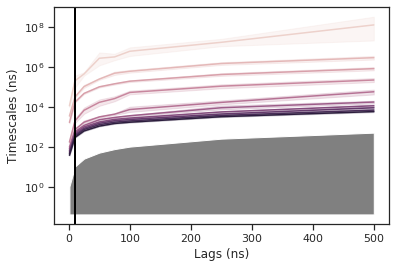

In [72]:
sns.set_context("notebook")
sns.set_style("ticks")
#plt.figure(figsize=(20,10))
df = pd.DataFrame(data_frame)
ax = sns.lineplot(x='Lags', y="Timescale", data=df, hue="Order", legend=False)
#plt.xlim([0.97,0.98])
plt.yscale("log")
plt.xlabel("Lags (ns)")
plt.ylabel("Timescales (ns)")

plt.fill_between(lags * steps_to_nanoseconds, 1*steps_to_nanoseconds, lags * steps_to_nanoseconds, facecolor='Gray')

#plt.axvline(250, linewidth=2, color='black')
plt.axvline(10, linewidth=2, color='black') # Set the us_lag in nanoseconds
plt.savefig('pics/msm_ts_over_lags.png', dpi=500)